In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msjahid/bean-crop-disease-diagnosis-and-spatial-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tqdm import trange
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
import seaborn as sns
sns.set()

In [3]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis')

['Classification', 'Detection']

In [4]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification')

['Classification']

In [5]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification')

['validation', 'training', 'test']

In [6]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/training')

['unknown', 'bean_rust', 'healthy', 'als']

In [7]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [8]:
train_dir = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/training'
test_dir = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/test'
val_dir = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/validation'

In [9]:
train_dataset = ImageFolder(train_dir, transform = transform)
test_dataset = ImageFolder(test_dir, transform = transform)
val_dataset = ImageFolder(val_dir, transform = transform)

In [10]:
#train_size = int(len(train_dataset) * 0.85)
#val_size = int(len(train_dataset) * 0.15)

In [11]:
#train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [11]:
for x, y in train_loader:
    print(f'Shape of X[N, C, H,W]: {x.shape}')
    print(f'Shape of y: {y.shape}{y.dtype}')
    break

Shape of X[N, C, H,W]: torch.Size([64, 3, 80, 80])
Shape of y: torch.Size([64])torch.int64


In [12]:
print(f'Classes are: {test_dataset.classes}')
num_classes = len(test_dataset.classes)
print(f'Number of classes: {num_classes}')

Classes are: ['als', 'bean_rust', 'healthy', 'unknown']
Number of classes: 4


In [13]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
          else 'cpu')

In [14]:
print(f'Using {device} device')

Using cuda device


In [3]:
def plot_results(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label = 'Train')
    axes[0].plot(xs, val_losses, label = 'Validation')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label = 'Train')
    axes[1].plot(xs, val_accs, label = 'Validation')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [16]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [17]:
def val_step(model, criterion, dataloader, device = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [18]:
def train_model(model, n_epochs,  optimizer, train_loader, val_loader, device = device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    plot_results(train_losses, train_accs, val_losses, val_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

In [19]:
class NN1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN1, self).__init__()
        self.network = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 128), nn.ReLU(),
                                    nn.Linear(128, 128), nn.ReLU(),
                                    nn.Linear(128, 64), nn.ReLU(),
                                    nn.Linear(64, 64), nn.ReLU(),
                                    nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss: 0.114 | Train Acc: 96.29 | Val Loss: 2.629 | Val Acc: 56.07: 100%|██████████| 30/30 [07:03<00:00, 14.13s/it]


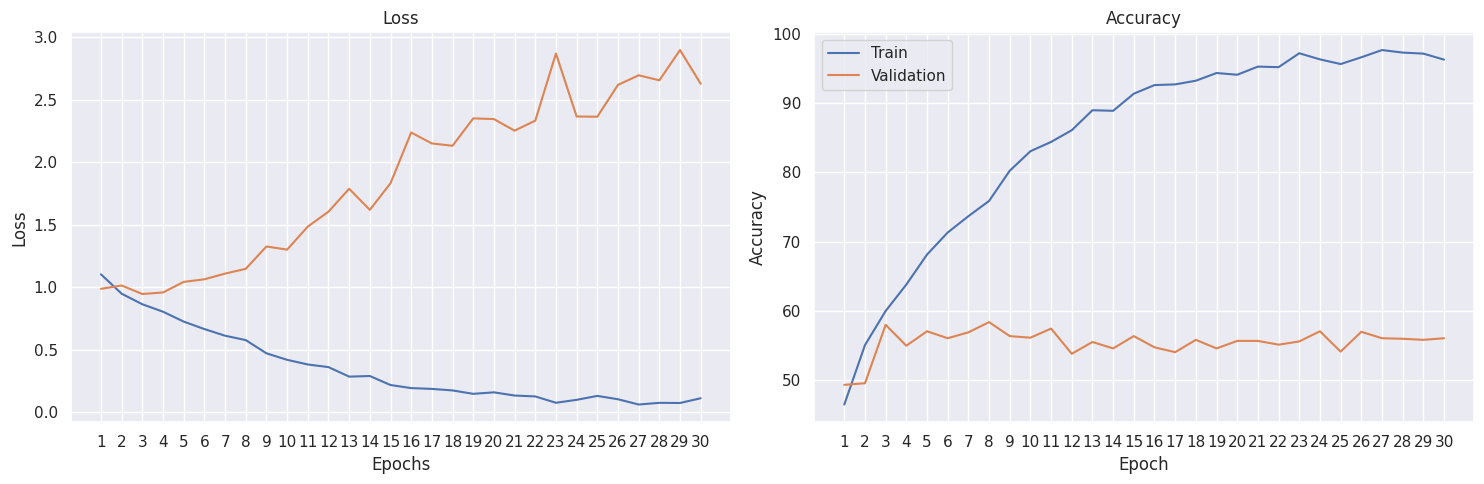

In [20]:
model = NN1(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, val_loader)

Train Loss: 1.285 | Train Acc: 30.05 | Val Loss: 1.301 | Val Acc: 29.62: 100%|██████████| 30/30 [07:01<00:00, 14.06s/it]


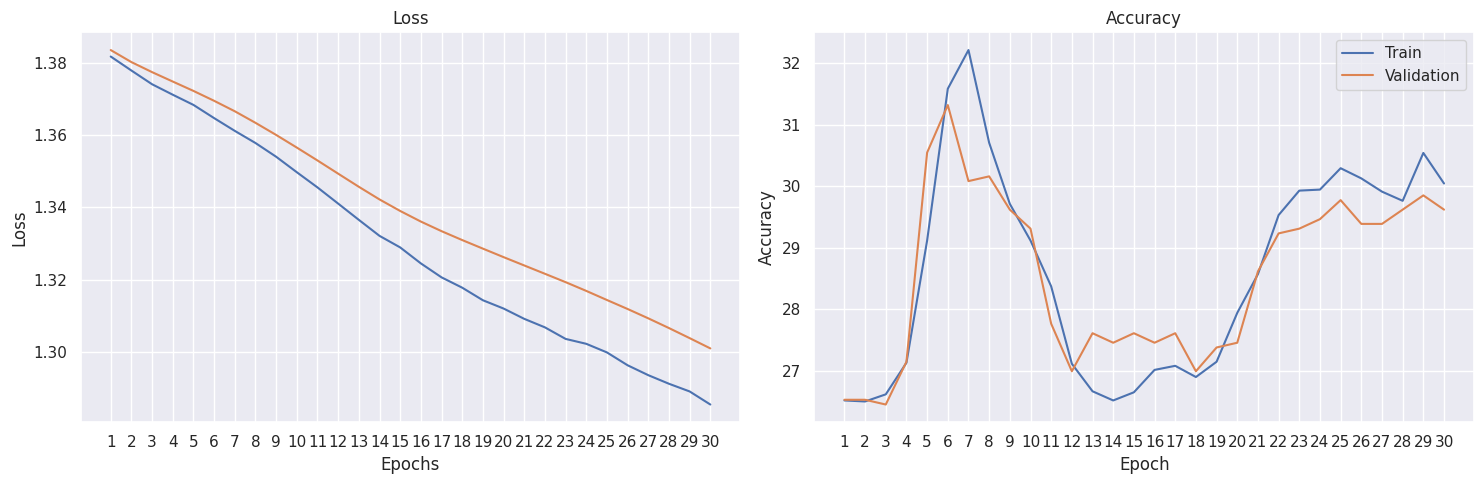

In [22]:
model = NN1(80*80*3, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, val_loader)

Train Loss: 0.381 | Train Acc: 87.12 | Val Loss: 1.051 | Val Acc: 56.84: 100%|██████████| 30/30 [06:55<00:00, 13.87s/it]


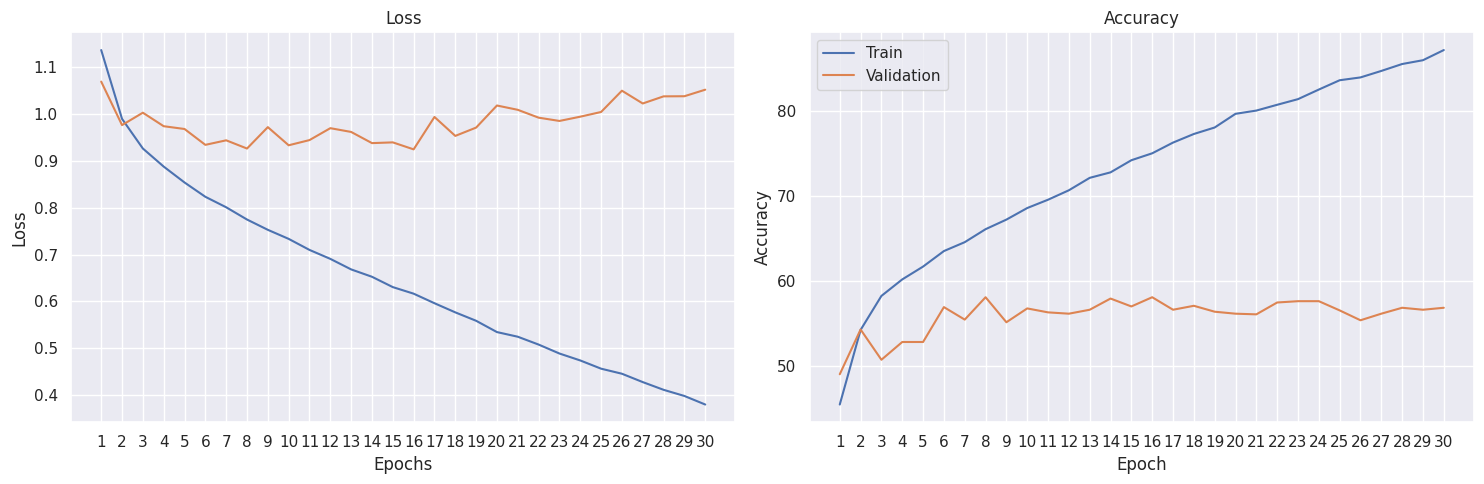

In [23]:
model = NN1(80*80*3, num_classes).to(device)
optimizer = optim.Adagrad(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, val_loader)

Train Loss: 0.139 | Train Acc: 95.89 | Val Loss: 2.923 | Val Acc: 50.81: 100%|██████████| 30/30 [06:56<00:00, 13.88s/it]


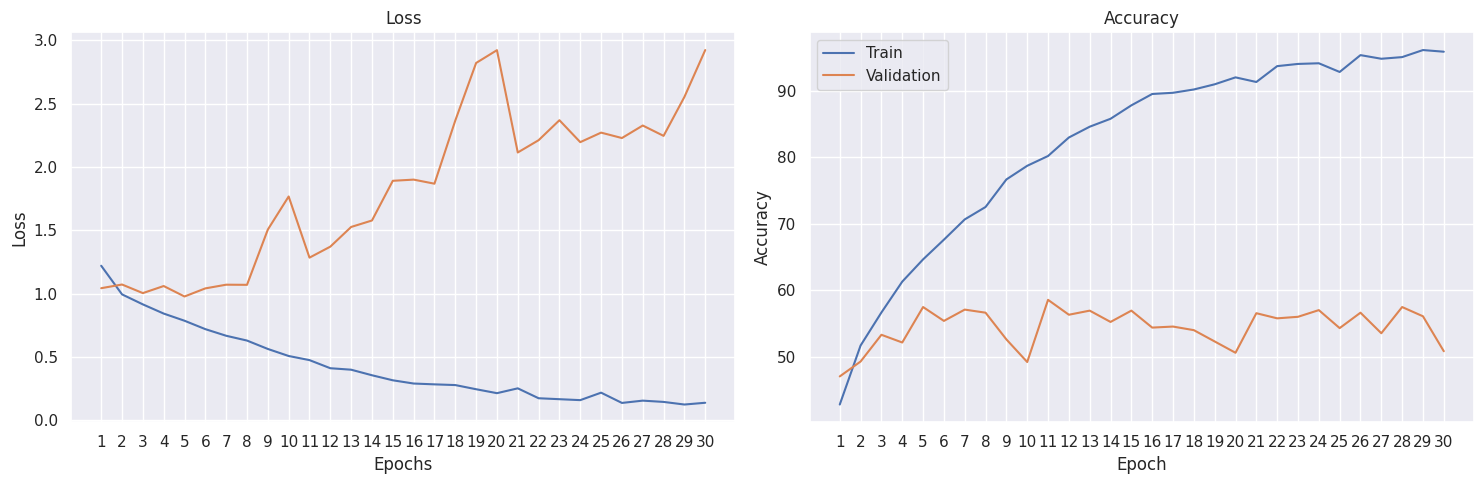

In [25]:
model = NN1(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, val_loader)

In [51]:
class CNN1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1, self).__init__()
        self.network = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.ReLU(),
                                    nn.Flatten(),
                                    nn.Linear(32*20*20, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, num_classes))

    def forward(self, x): 
        return self.network(x)

Train Loss: 0.001 | Train Acc: 100.00 | Val Loss: 2.110 | Val Acc: 68.60: 100%|██████████| 20/20 [06:19<00:00, 18.98s/it]


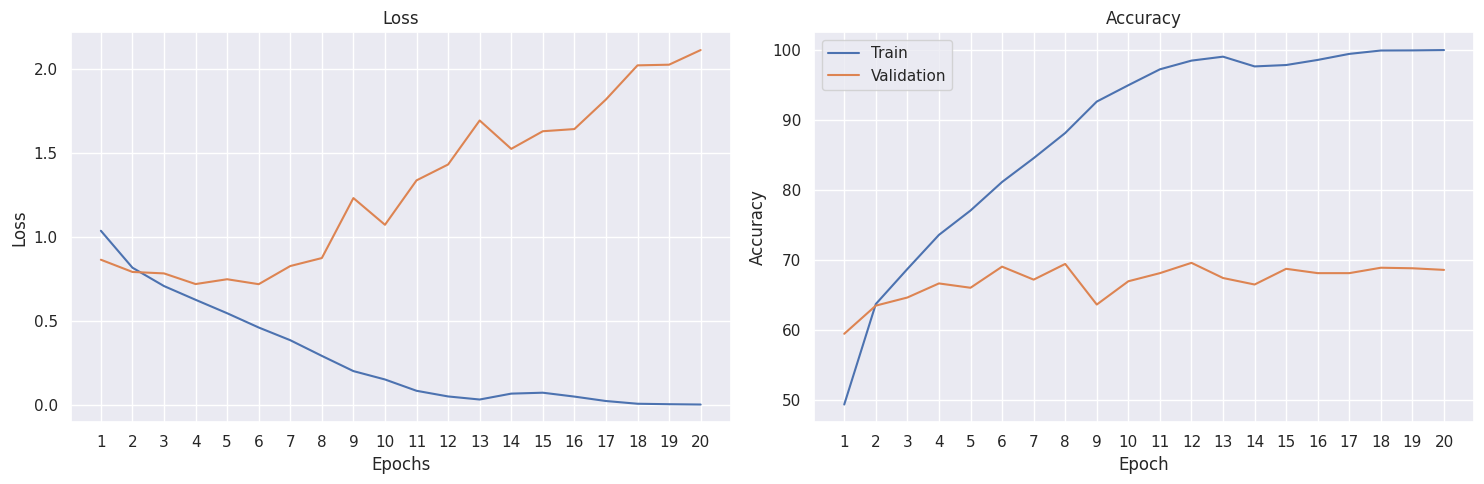

In [52]:
model = CNN1(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [64]:
class CNN2(nn.Module):
    def __init__(self,input_size, num_classes):
        super(CNN2, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*20*20, 128),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss: 0.166 | Train Acc: 93.93 | Val Loss: 1.056 | Val Acc: 71.15: 100%|██████████| 20/20 [05:30<00:00, 16.51s/it]


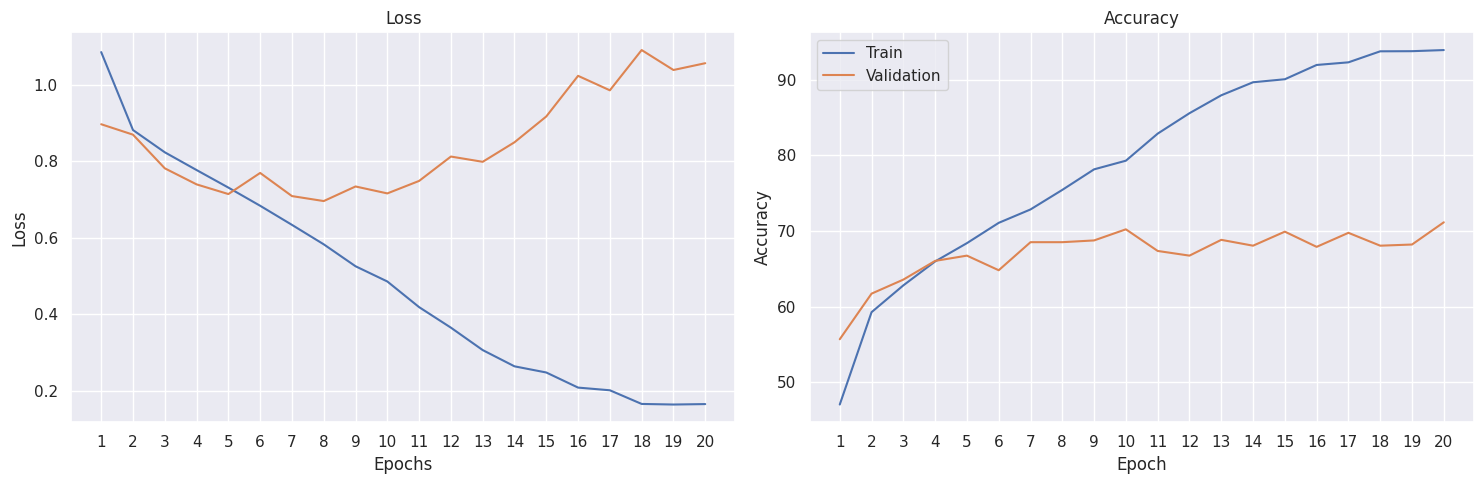

In [65]:
model = CNN2(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [66]:
class CNN3(nn.Module):
    def __init__(self,input_size, num_classes):
        super(CNN3, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Dropout(0.50),
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Dropout(0.50),
        nn.Flatten(),
        nn.Linear(32*20*20, 128),
        nn.ReLU(),
        nn.Dropout(0.50),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.50),
        nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss: 0.594 | Train Acc: 75.29 | Val Loss: 0.675 | Val Acc: 71.08: 100%|██████████| 20/20 [05:14<00:00, 15.70s/it]


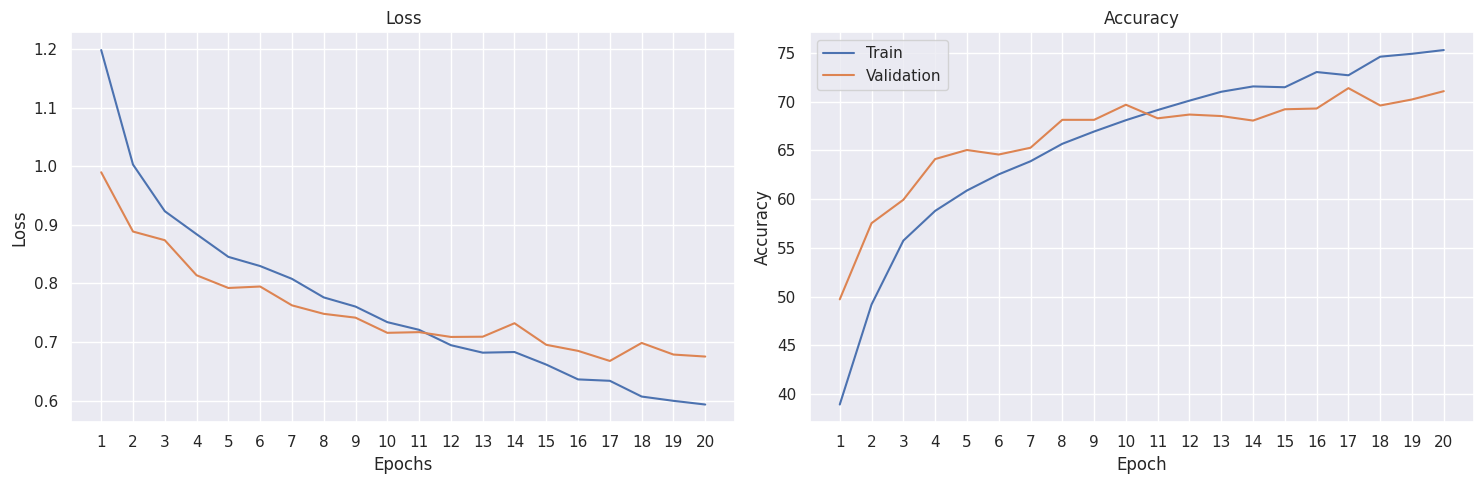

In [67]:
model = CNN3(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [74]:
class CNN4(nn.Module):
    def __init__(self,input_size, num_classes):
        super(CNN4, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*20*20, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, num_classes))

    def forward(self, x):
        return self.network(x)

Train Loss: 0.006 | Train Acc: 99.93 | Val Loss: 1.288 | Val Acc: 68.37: 100%|██████████| 20/20 [05:15<00:00, 15.80s/it]


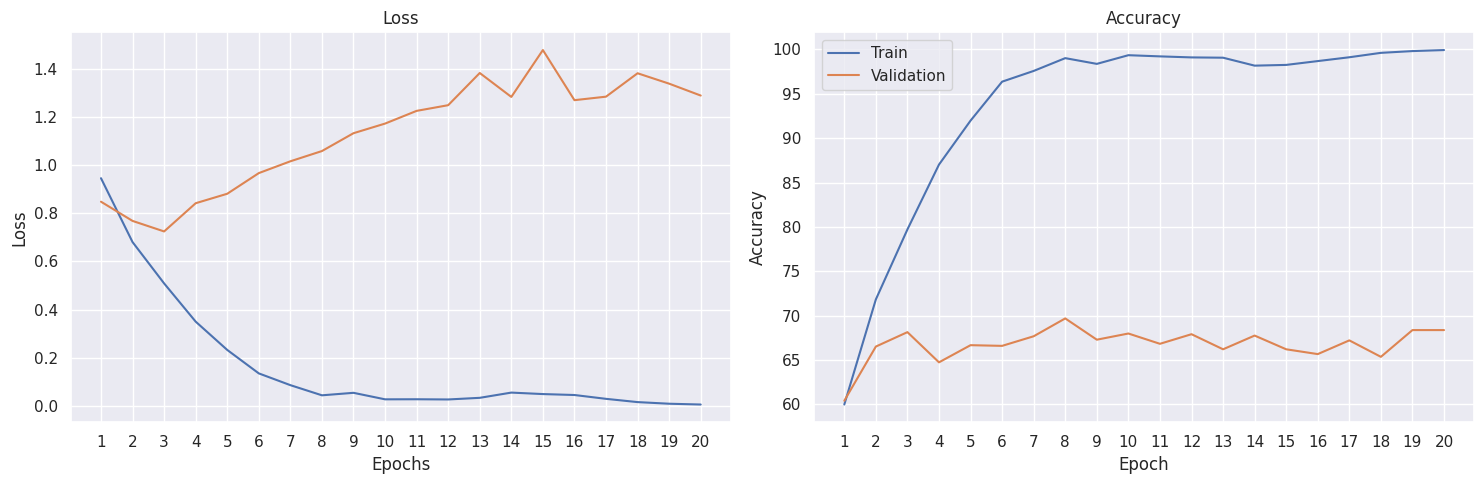

In [76]:
model = CNN4(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [79]:
class CNN5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN5, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.59),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.397 | Train Acc: 83.94 | Val Loss: 0.706 | Val Acc: 70.84: 100%|██████████| 20/20 [05:07<00:00, 15.36s/it]


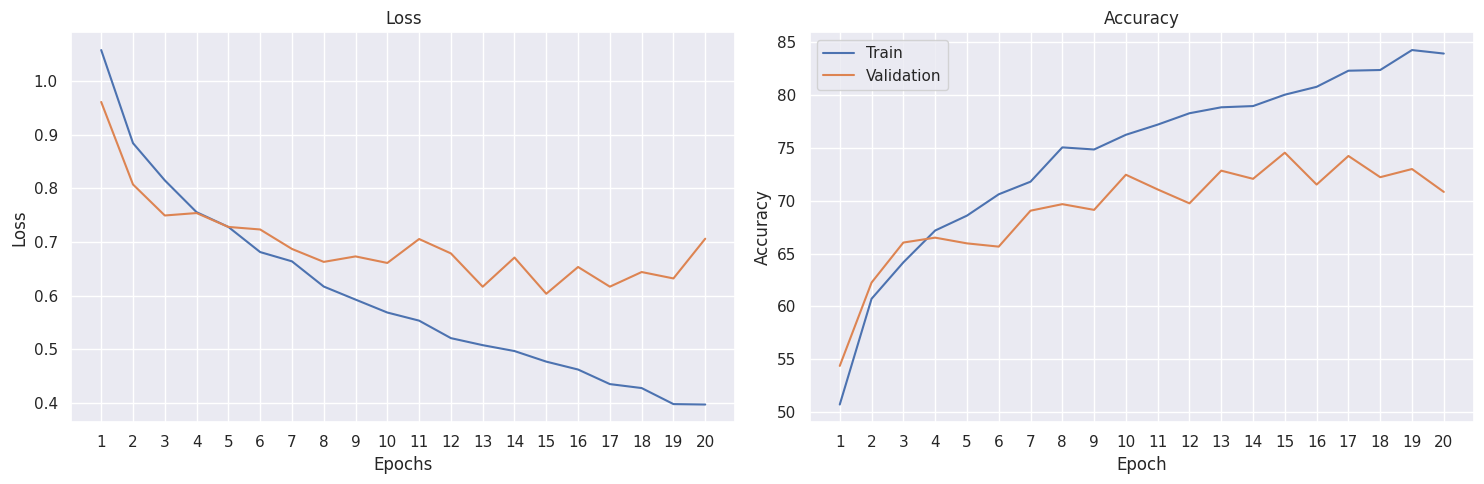

In [80]:
model = CNN5(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [81]:
class CNN6(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN6, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.70),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.50),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.70),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.540 | Train Acc: 77.78 | Val Loss: 0.675 | Val Acc: 69.68: 100%|██████████| 20/20 [05:06<00:00, 15.31s/it]


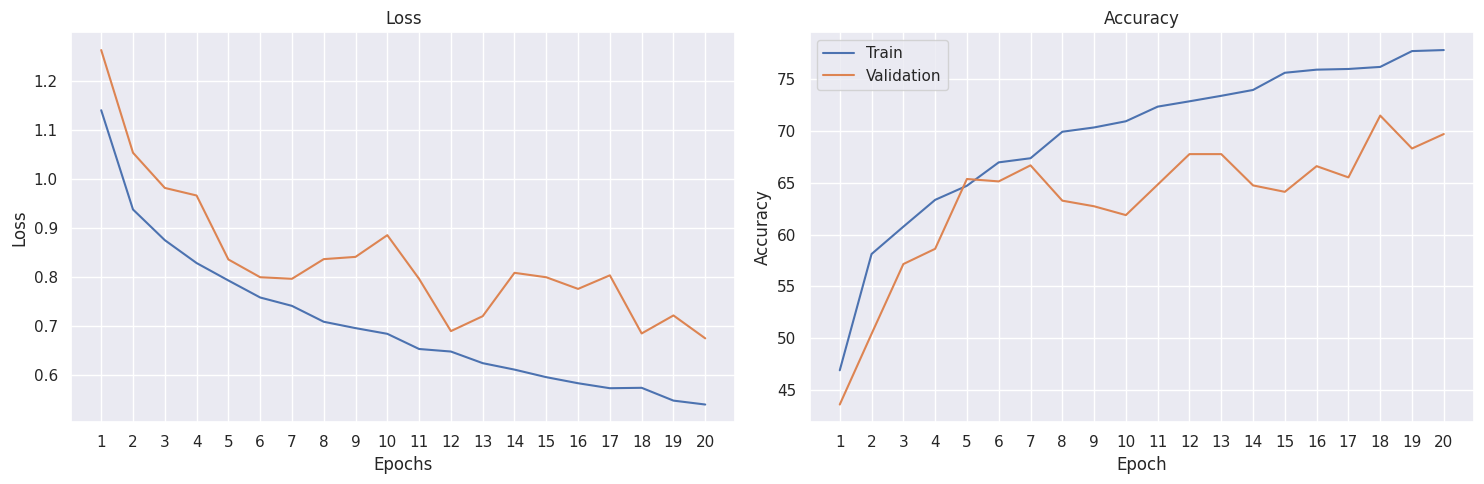

In [82]:
model = CNN6(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [86]:
class CNN7(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN7, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.650 | Train Acc: 72.89 | Val Loss: 0.677 | Val Acc: 71.62: 100%|██████████| 20/20 [05:05<00:00, 15.28s/it]


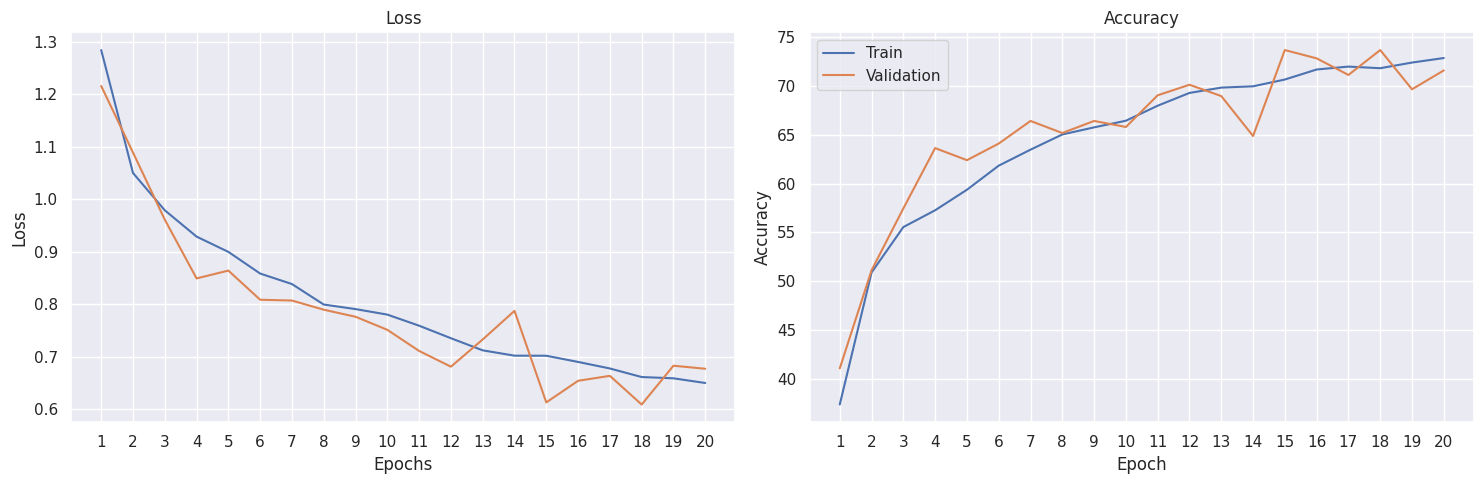

In [87]:
model = CNN7(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [88]:
class CNN8(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN8, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.699 | Train Acc: 70.90 | Val Loss: 0.657 | Val Acc: 72.08: 100%|██████████| 20/20 [05:05<00:00, 15.26s/it]


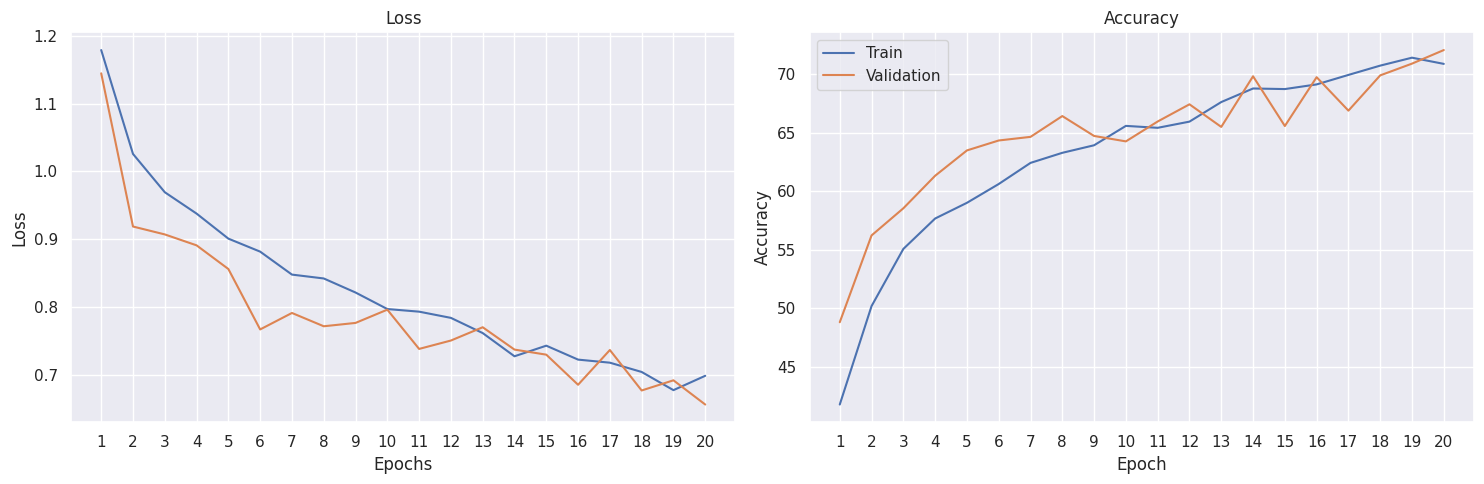

In [89]:
model = CNN8(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [90]:
class CNN8_2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN8_2, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.561 | Train Acc: 77.73 | Val Loss: 0.773 | Val Acc: 67.05: 100%|██████████| 40/40 [10:15<00:00, 15.39s/it]


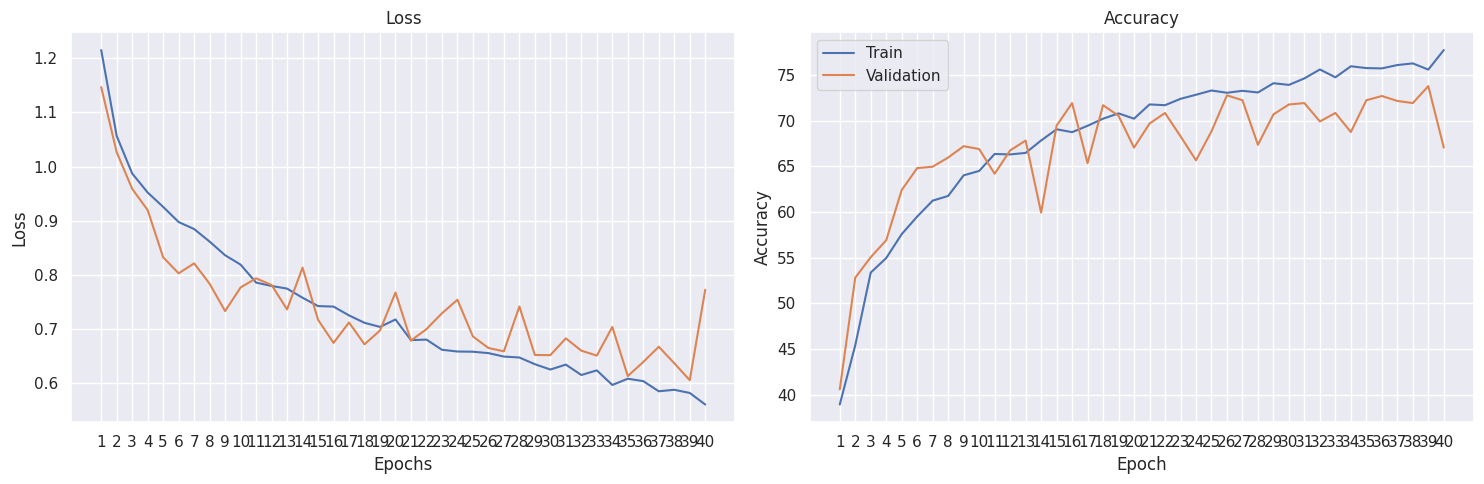

In [91]:
model = CNN8_2(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
results = train_model(model, 40, optimizer, train_loader, val_loader)

In [92]:
class CNN7_2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN7_2, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.526 | Train Acc: 78.44 | Val Loss: 0.700 | Val Acc: 69.14: 100%|██████████| 40/40 [10:23<00:00, 15.59s/it]


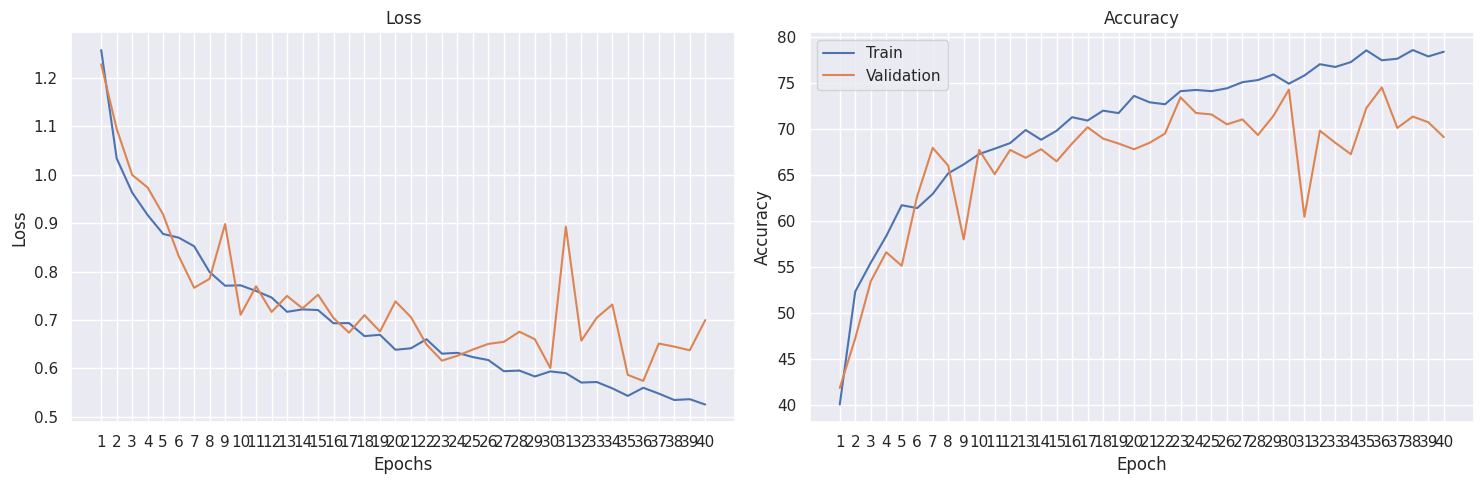

In [93]:
model = CNN7_2(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 40, optimizer, train_loader, val_loader)

In [94]:
class CNN9(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN9, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1, stride = 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Flatten(),
            nn.Linear(32*20*20, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.65),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.904 | Train Acc: 59.35 | Val Loss: 1.226 | Val Acc: 42.30: 100%|██████████| 20/20 [05:07<00:00, 15.39s/it]


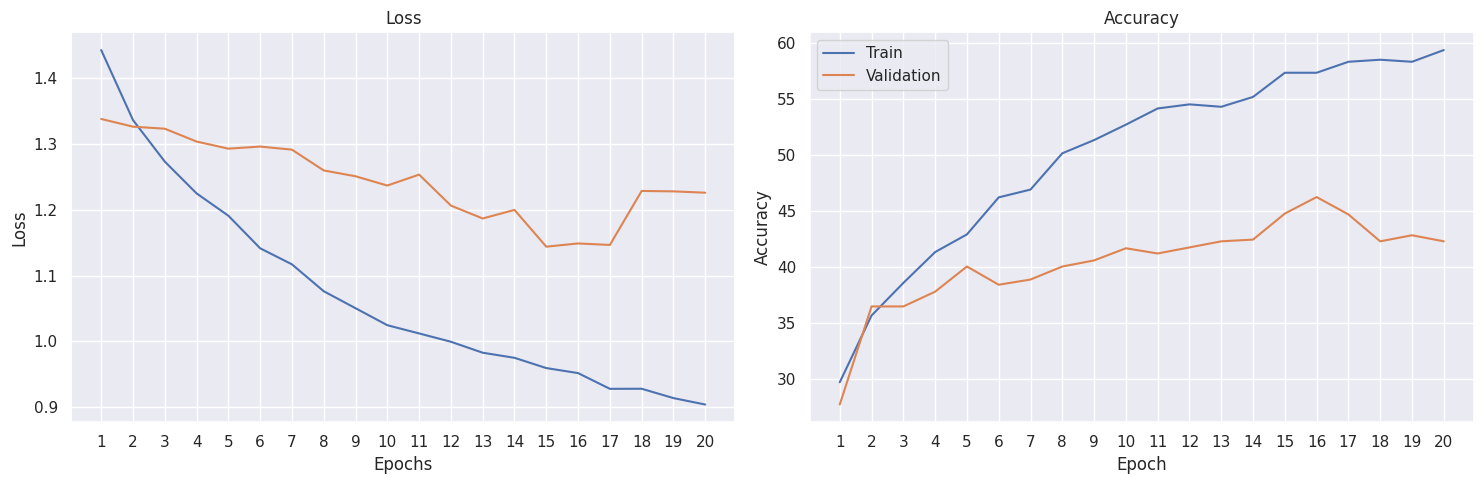

In [95]:
model = CNN9(80*80*3, num_classes = num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

The CNN7 model is the best model

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Input, ReLU
from keras.callbacks import EarlyStopping
import pandas as pd
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
sns.set()

In [5]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis')

['Classification', 'Detection']

In [6]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification')

['Classification']

In [7]:
os.listdir('/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification')

['validation', 'training', 'test']

In [5]:
training_path = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/training'
test_path = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/test'
validation_path = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification/validation'

In [6]:
def image_label_ext(path):
    images, labels = [], []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            img_path = os.path.join(path, i, j)
            img = cv2.imread(img_path)
            if img is None:
                print(img_path)
            else:
                resized_img = cv2.resize(img, (80, 80))
                images.append(resized_img)
                labels.append(i)
    return images, labels

In [7]:
training_images, training_labels = image_label_ext(training_path)

In [8]:
test_images, test_labels = image_label_ext(test_path)

In [9]:
valid_images, valid_labels = image_label_ext(validation_path)

In [26]:
print(f'Size of Training set: {len(training_images)}')
print(f'Size of Test set: {len(test_images)}')
print(f'Size of Validation set: {len(valid_images)}')

Size of Training set: 6034
Size of Test set: 1296
Size of Validation set: 1293


In [10]:
X_train, y_train = shuffle(training_images, training_labels, random_state = 101)
X_test, y_test = shuffle(test_images, test_labels, random_state = 101)
X_val, y_val = shuffle(valid_images, valid_labels, random_state = 101)

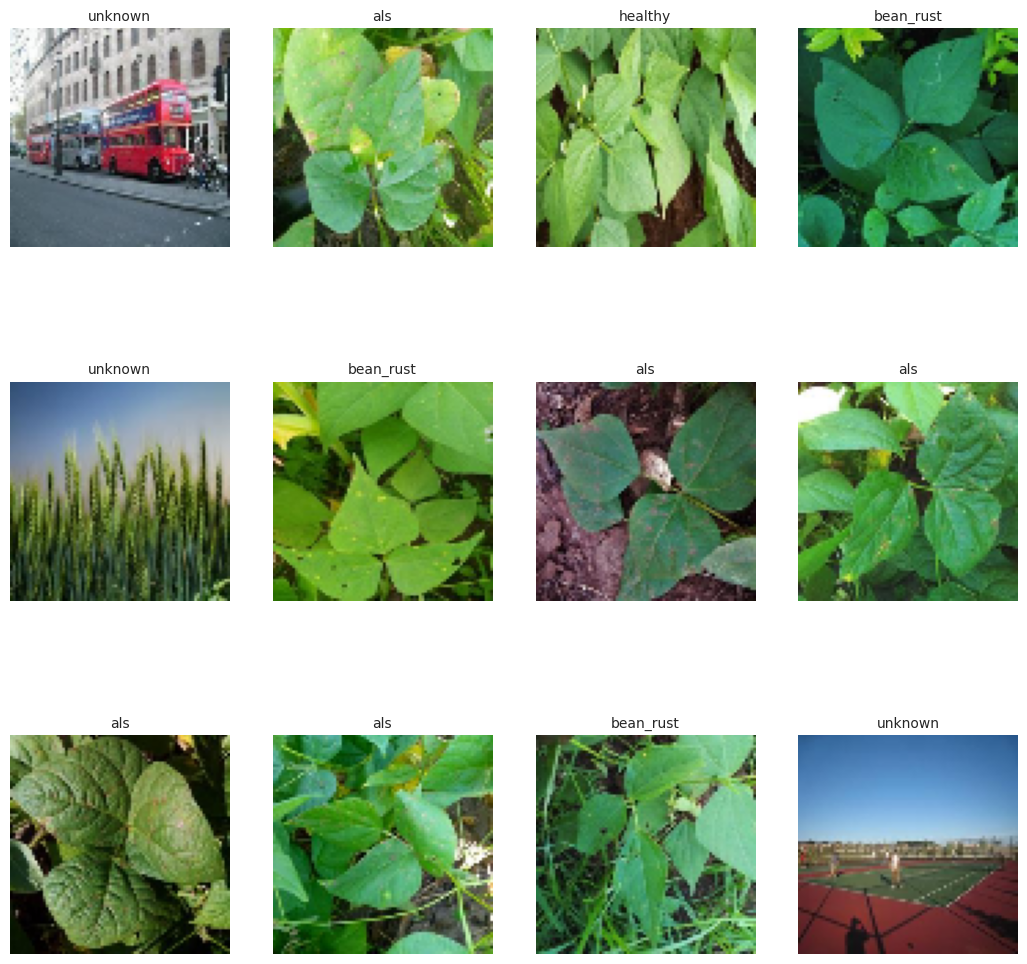

In [34]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    im = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.title(y_train[i], fontsize = 10)
    plt.axis('off')

In [11]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_valid_le = le.transform(y_val)

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [13]:
X_train_scaled = X_train / 255

In [14]:
X_test_scaled = X_test / 255

In [15]:
X_val_scaled = X_val / 255

In [50]:
df_label = pd.DataFrame({
    'label': y_train
}
)
print('Number of labels:', df_label['label'].nunique())
print('Labels are:', df_label['label'].unique())

Number of labels: 4
Labels are: ['unknown' 'als' 'healthy' 'bean_rust']


In [71]:
early_stopping1 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [72]:
model1 = Sequential()

In [73]:
model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(4, activation = 'softmax'))

In [74]:
model1.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [75]:
history1 = model1.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping1])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3134 - loss: 1.5206 - val_accuracy: 0.4540 - val_loss: 1.1408
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4470 - loss: 1.1371 - val_accuracy: 0.3852 - val_loss: 1.2387
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4766 - loss: 1.0829 - val_accuracy: 0.4493 - val_loss: 1.0716
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 1.0689 - val_accuracy: 0.4749 - val_loss: 1.0699
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5562 - loss: 0.9585 - val_accuracy: 0.4741 - val_loss: 1.0336
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5465 - loss: 0.9653 - val_accuracy: 0.4903 - val_loss: 1.0245
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5515 - loss: 0.9549 - val_accuracy: 0.5360 - val_loss: 0.9778
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5500 - loss: 0.9495 - val_acc

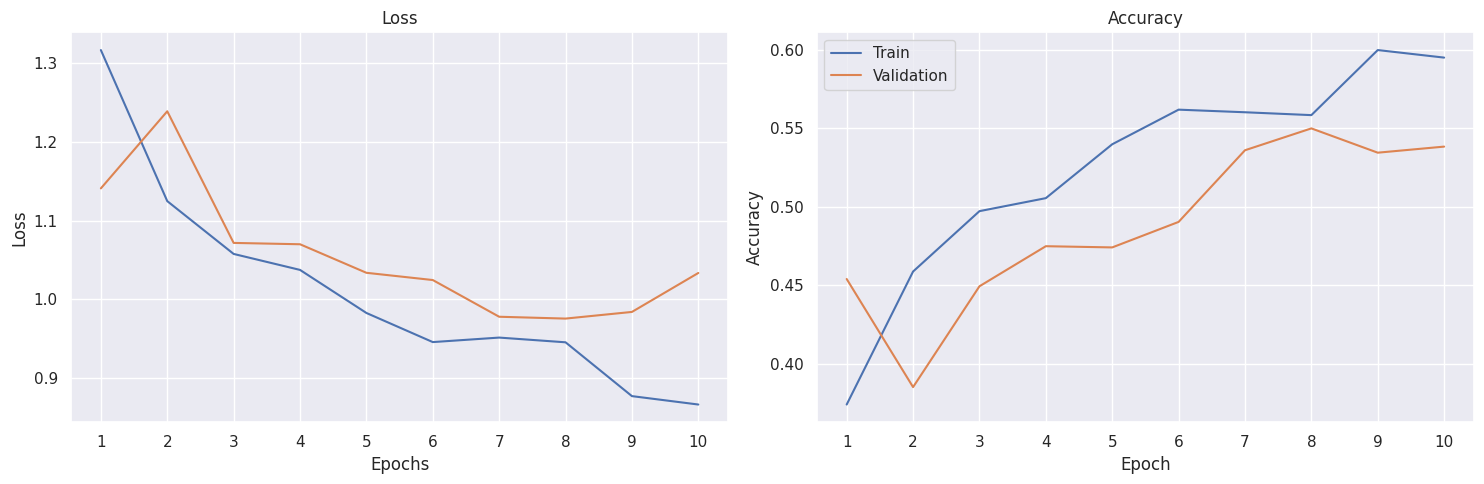

In [78]:
plot_results(history1.history['loss'], history1.history['accuracy'], history1.history['val_loss'], history1.history['val_accuracy'])

In [84]:
early_stopping1_2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [85]:
model1_2 = Sequential()

In [86]:
model1_2.add(Flatten())
model1_2.add(Dense(128, activation = 'relu'))
model1_2.add(Dense(128, activation = 'relu'))
model1_2.add(Dense(64, activation = 'relu'))
model1_2.add(Dense(64, activation = 'relu'))
model1_2.add(Dense(4, activation = 'softmax'))

In [87]:
model1_2.compile(
    optimizer = SGD(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [88]:
history1_2 = model1_2.fit(X_train_scaled, y_train_le , validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping2])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3012 - loss: 1.3527 - val_accuracy: 0.3774 - val_loss: 1.2715
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3825 - loss: 1.2561 - val_accuracy: 0.4060 - val_loss: 1.1972
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4172 - loss: 1.1952 - val_accuracy: 0.4045 - val_loss: 1.1649
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4361 - loss: 1.1593 - val_accuracy: 0.4370 - val_loss: 1.1376
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4615 - loss: 1.1267 - val_accuracy: 0.4370 - val_loss: 1.1256
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4861 - loss: 1.1125 - val_accuracy: 0.4625 - val_loss: 1.0974
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4966 - loss: 1.0789 - val_accuracy: 0.4811 - val_loss: 1.0755
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4876 - loss: 1.0689 - val_acc

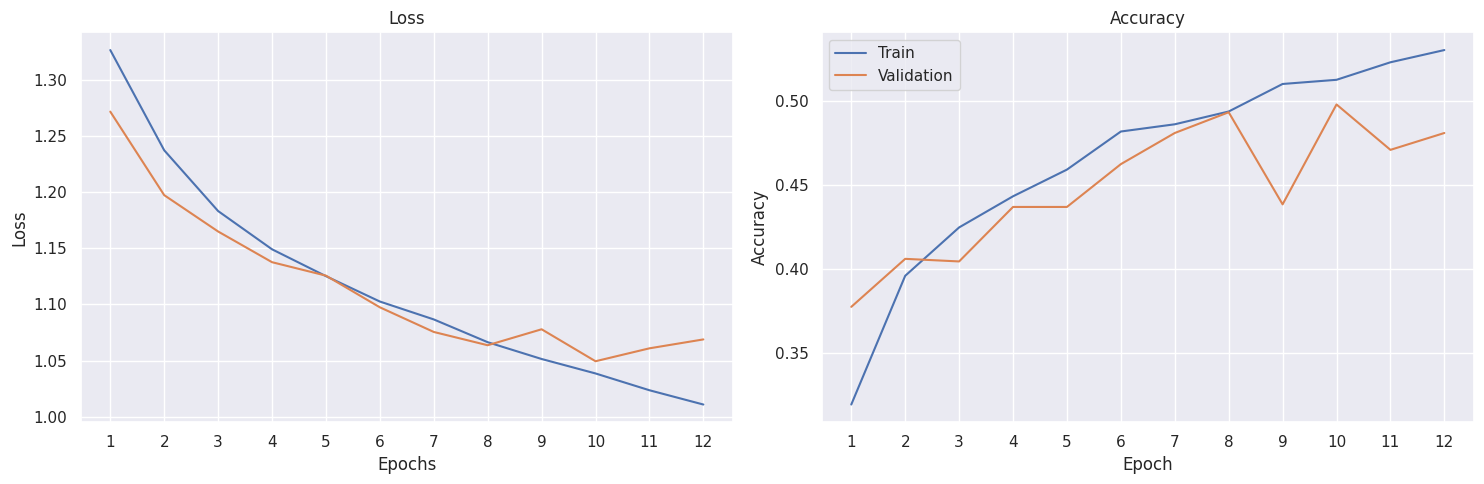

In [89]:
plot_results(history1_2.history['loss'], history1_2.history['accuracy'], history1_2.history['val_loss'], history1_2.history['val_accuracy'])

In [96]:
early_stopping1_3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [97]:
model1_3 = Sequential()

In [98]:
model1_3.add(Flatten())
model1_3.add(Dense(128, activation = 'relu'))
model1_3.add(Dense(128, activation = 'relu'))
model1_3.add(Dense(64, activation = 'relu'))
model1_3.add(Dense(64, activation = 'relu'))
model1_3.add(Dense(4, activation = 'softmax'))

In [99]:
model1_3.compile(
    optimizer = Adagrad(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [100]:
history1_3 = model1_3.fit(X_train_scaled, y_train_le , validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping1_3])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3211 - loss: 1.3266 - val_accuracy: 0.3921 - val_loss: 1.1854
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4267 - loss: 1.1826 - val_accuracy: 0.4045 - val_loss: 1.1586
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4657 - loss: 1.1139 - val_accuracy: 0.4671 - val_loss: 1.1073
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4964 - loss: 1.0787 - val_accuracy: 0.5027 - val_loss: 1.0625
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5078 - loss: 1.0607 - val_accuracy: 0.4834 - val_loss: 1.0488
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5255 - loss: 1.0351 - val_accuracy: 0.5027 - val_loss: 1.0589
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5362 - loss: 1.0147 - val_accuracy: 0.4509 - val_loss: 1.0696


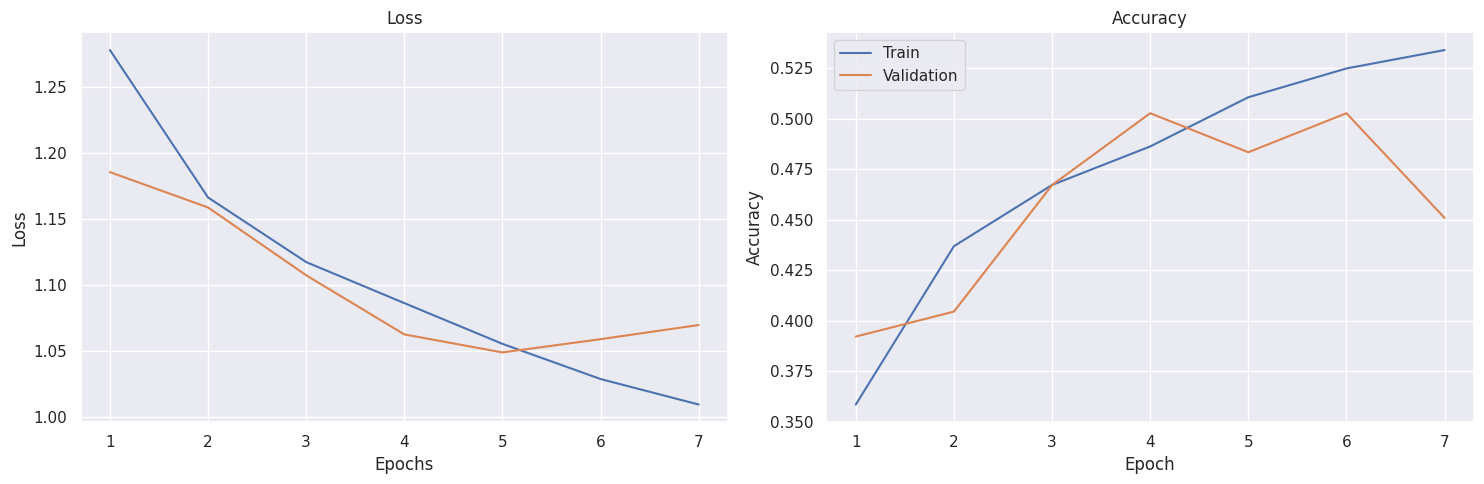

In [101]:
plot_results(history1_3.history['loss'], history1_3.history['accuracy'], history1_3.history['val_loss'], history1_3.history['val_accuracy'])

In [103]:
early_stopping1_4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [104]:
model1_4 = Sequential()

In [105]:
model1_4.add(Flatten())
model1_4.add(Dense(128, activation = 'relu'))
model1_4.add(Dense(128, activation = 'relu'))
model1_4.add(Dense(64, activation = 'relu'))
model1_4.add(Dense(64, activation = 'relu'))
model1_4.add(Dense(4, activation = 'softmax'))

In [106]:
model1_4.compile(
    optimizer = Adagrad(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [107]:
history1_4 = model1_4.fit(X_train_scaled, y_train_le , validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping1_4])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3256 - loss: 1.3356 - val_accuracy: 0.4068 - val_loss: 1.1948
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4242 - loss: 1.1833 - val_accuracy: 0.4695 - val_loss: 1.1202
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4532 - loss: 1.1364 - val_accuracy: 0.4872 - val_loss: 1.0878
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4823 - loss: 1.0923 - val_accuracy: 0.4834 - val_loss: 1.0812
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5113 - loss: 1.0578 - val_accuracy: 0.5058 - val_loss: 1.0658
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5335 - loss: 1.0235 - val_accuracy: 0.4996 - val_loss: 1.0438
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5296 - loss: 1.0155 - val_accuracy: 0.4981 - val_loss: 1.0266
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5539 - loss: 0.9916 - val_acc

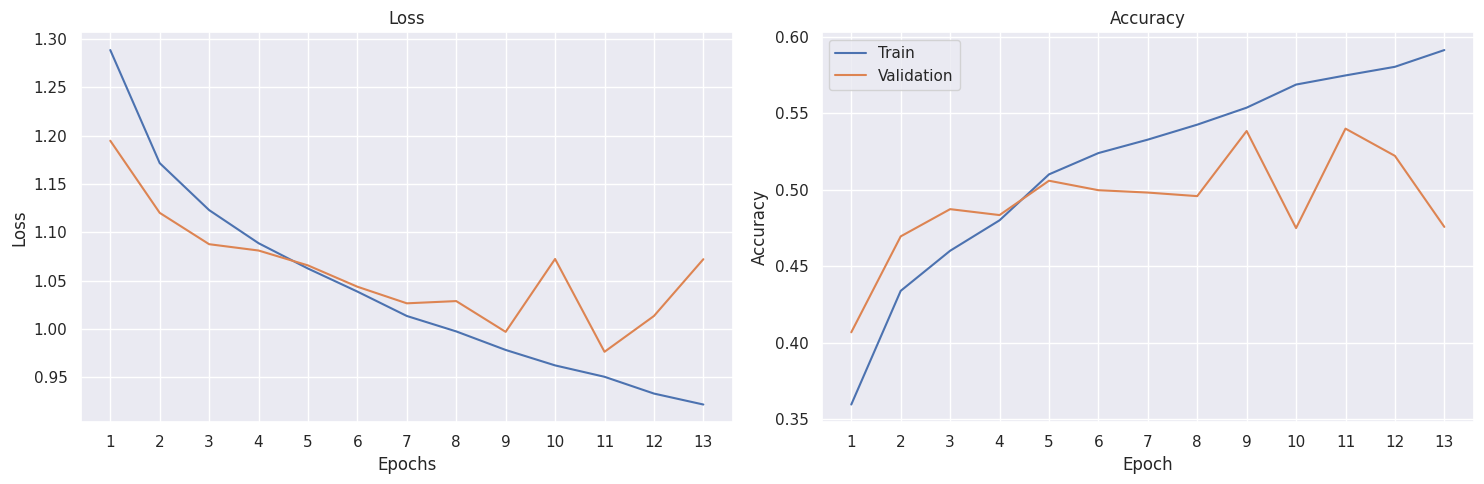

In [108]:
plot_results(history1_4.history['loss'], history1_4.history['accuracy'], history1_4.history['val_loss'], history1_4.history['val_accuracy'])

In [125]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [126]:
model2 = Sequential()

In [127]:
model2.add(Input(shape = (80, 80, 3)))
model2.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(4, activation = 'softmax'))

In [128]:
model2.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [129]:
history2 = model2.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping2])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.3838 - loss: 1.2243 - val_accuracy: 0.4919 - val_loss: 0.9986
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5677 - loss: 0.9204 - val_accuracy: 0.6172 - val_loss: 0.8383
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6466 - loss: 0.7870 - val_accuracy: 0.6512 - val_loss: 0.7849
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7070 - loss: 0.6688 - val_accuracy: 0.6690 - val_loss: 0.7733
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7612 - loss: 0.5611 - val_accuracy: 0.6767 - val_loss: 0.7675
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8180 - loss: 0.4532 - val_accuracy: 0.6721 - val_loss: 0.8002
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8795 - loss: 0.3201 - val_accuracy: 0.6404 - val_loss: 0.9968


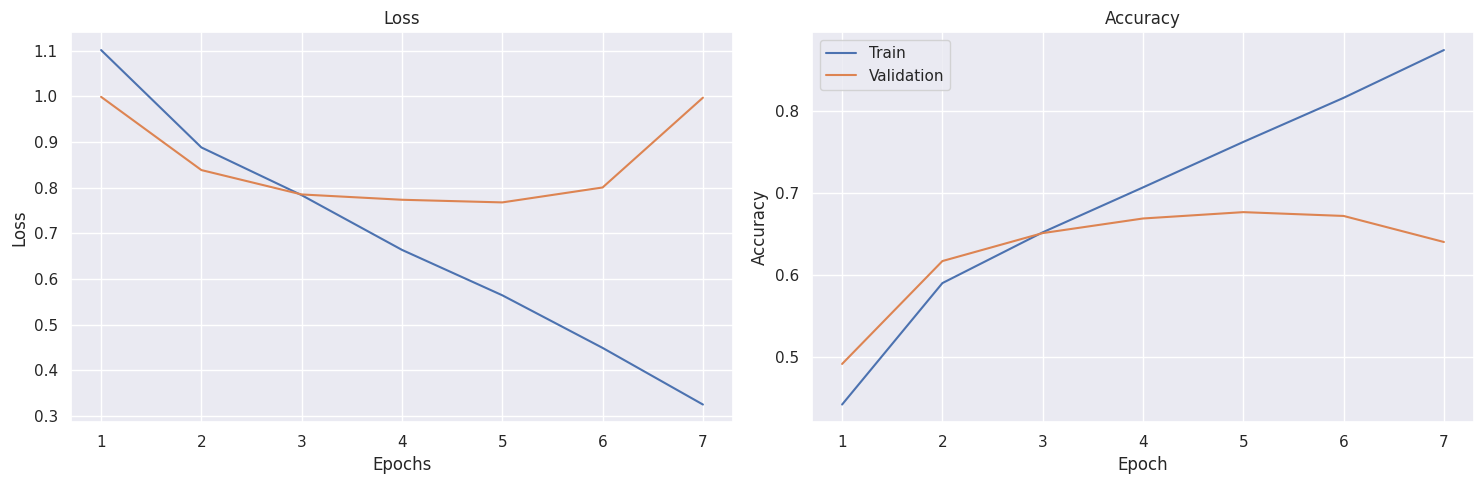

In [130]:
plot_results(history2.history['loss'], history2.history['accuracy'], history2.history['val_loss'], history2.history['val_accuracy'])

In [134]:
early_stopping2_2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [135]:
model2_2 = Sequential()

In [136]:
model2_2.add(Input(shape = (80, 80, 3)))
model2_2.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2_2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2_2.add(Dropout(0.25))
model2_2.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2_2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2_2.add(Dropout(0.25))
model2_2.add(Flatten())
model2_2.add(Dense(128, activation = 'relu'))
model2_2.add(Dropout(0.25))
model2_2.add(Dense(64, activation = 'relu'))
model2_2.add(Dropout(0.25))
model2_2.add(Dense(4, activation = 'softmax'))

In [137]:
model2_2.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [138]:
history2_2 = model2_2.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping2_2])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3368 - loss: 1.2856 - val_accuracy: 0.4834 - val_loss: 1.0404
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4951 - loss: 1.0002 - val_accuracy: 0.5754 - val_loss: 0.8757
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5569 - loss: 0.9181 - val_accuracy: 0.6063 - val_loss: 0.8484
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6046 - loss: 0.8556 - val_accuracy: 0.6257 - val_loss: 0.8302
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6508 - loss: 0.7754 - val_accuracy: 0.6620 - val_loss: 0.7761
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6819 - loss: 0.7318 - val_accuracy: 0.6489 - val_loss: 0.7885
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7001 - loss: 0.6875 - val_accuracy: 0.6721 - val_loss: 0.7427
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7454 - loss: 0.6051 - val_ac

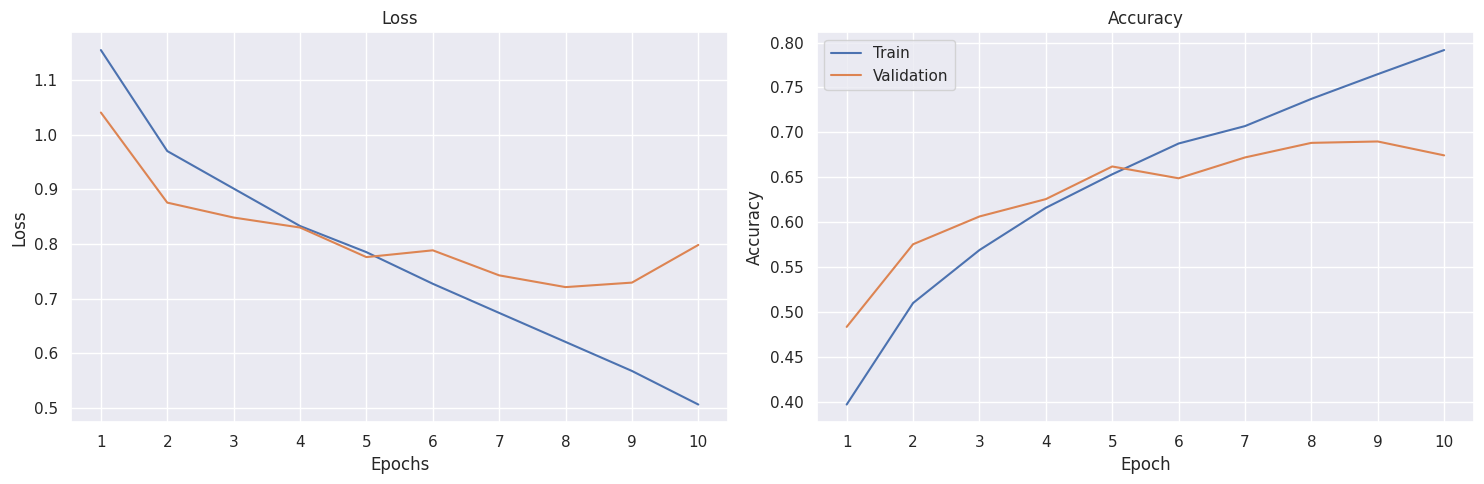

In [140]:
plot_results(history2_2.history['loss'], history2_2.history['accuracy'], history2_2.history['val_loss'], history2_2.history['val_accuracy'])

In [149]:
early_stopping2_3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [150]:
model2_3 = Sequential()

In [151]:
model2_3.add(Input(shape = (80, 80, 3)))
model2_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2_3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2_3.add(Dropout(0.50))
model2_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu'))
model2_3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model2_3.add(Dropout(0.50))
model2_3.add(Flatten())
model2_3.add(Dense(128, activation = 'relu'))
model2_3.add(Dropout(0.50))
model2_3.add(Dense(64, activation = 'relu'))
model2_3.add(Dropout(0.50))
model2_3.add(Dense(4, activation = 'softmax'))

In [152]:
model2_3.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [153]:
history2_3 = model2_3.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping2_3])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2874 - loss: 1.3990 - val_accuracy: 0.3875 - val_loss: 1.3091
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4126 - loss: 1.1613 - val_accuracy: 0.4764 - val_loss: 0.9982
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4460 - loss: 1.0340 - val_accuracy: 0.4988 - val_loss: 1.0383
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4708 - loss: 1.0021 - val_accuracy: 0.5321 - val_loss: 0.9892
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4981 - loss: 0.9811 - val_accuracy: 0.5220 - val_loss: 0.9670
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5103 - loss: 0.9665 - val_accuracy: 0.5661 - val_loss: 0.9195
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5251 - loss: 0.9449 - val_accuracy: 0.5592 - val_loss: 0.9008
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5457 - loss: 0.9297 - val_ac

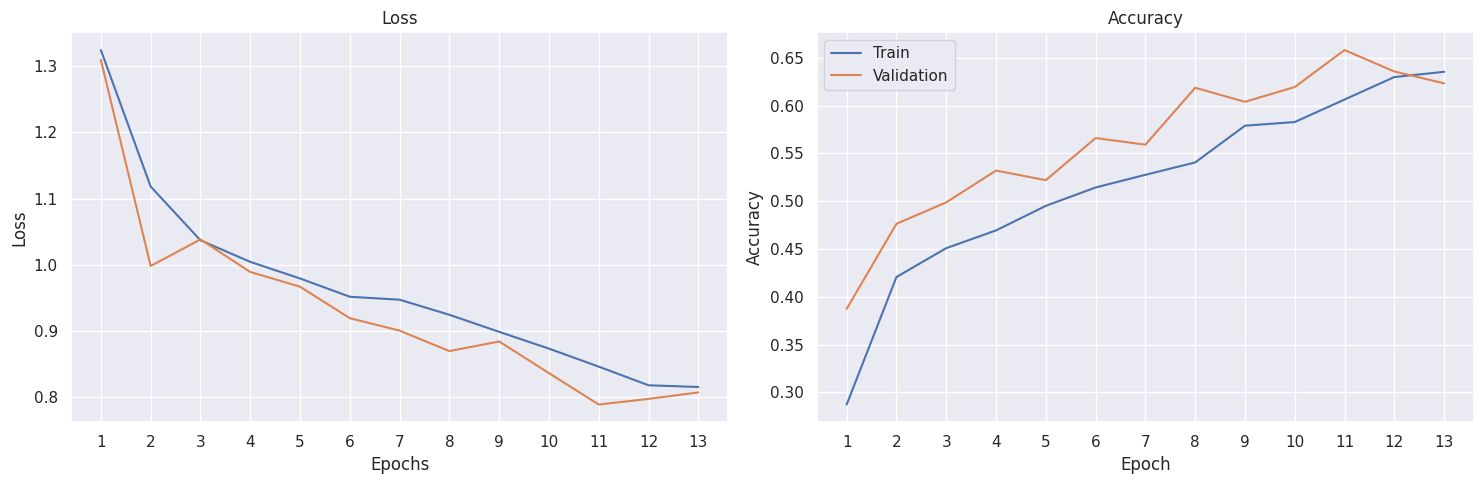

In [154]:
plot_results(history2_3.history['loss'], history2_3.history['accuracy'], history2_3.history['val_loss'], history2_3.history['val_accuracy'])

In [164]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [165]:
model3 = Sequential()

In [166]:
model3.add(Input(shape = (80, 80, 3)))
model3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3.add(Dropout(0.50))
model3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3.add(Dropout(0.50))
model3.add(Flatten())
model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(Dense(64))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(Dropout(0.50))
model3.add(Dense(4, activation = 'softmax'))

In [167]:
model3.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [168]:
history3 = model3.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping3])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4103 - loss: 1.3830 - val_accuracy: 0.2900 - val_loss: 2.0124
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5718 - loss: 0.9731 - val_accuracy: 0.3326 - val_loss: 1.5422
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6286 - loss: 0.8534 - val_accuracy: 0.5066 - val_loss: 1.0099
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6464 - loss: 0.8011 - val_accuracy: 0.4524 - val_loss: 1.3322
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6720 - loss: 0.7614 - val_accuracy: 0.6288 - val_loss: 0.7965
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6928 - loss: 0.7265 - val_accuracy: 0.6257 - val_loss: 0.7892
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7303 - loss: 0.6592 - val_accuracy: 0.5507 - val_loss: 1.0680
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7388 - loss: 0.6288 -

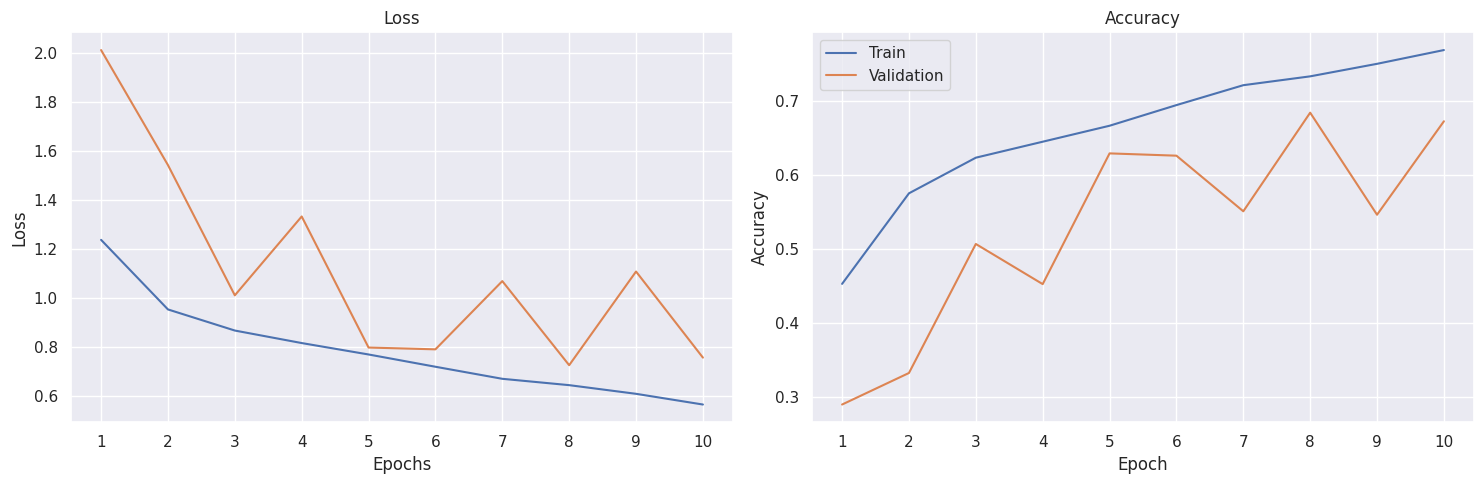

In [169]:
plot_results(history3.history['loss'], history3.history['accuracy'], history3.history['val_loss'], history3.history['val_accuracy'])

In [187]:
early_stopping3_2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [188]:
model3_2 = Sequential()

In [189]:
model3_2.add(Input(shape = (80, 80, 3)))
model3_2.add(Conv2D(64, (3, 3), padding = 'same', strides = 1))
model3_2.add(BatchNormalization())
model3_2.add(ReLU())
model3_2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3_2.add(Dropout(0.65))
model3_2.add(Conv2D(32, (3, 3), padding = 'same', strides = 1))
model3_2.add(BatchNormalization())
model3_2.add(ReLU())
model3_2.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3_2.add(Dropout(0.65))
model3_2.add(Flatten())
model3_2.add(Dense(128))
model3_2.add(BatchNormalization())
model3_2.add(ReLU())
model3_2.add(Dense(64))
model3_2.add(BatchNormalization())
model3_2.add(ReLU())
model3_2.add(Dropout(0.65))
model3_2.add(Dense(4, activation = 'softmax'))

In [190]:
model3_2.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [191]:
history3_2 = model3_2.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping3_2])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.3708 - loss: 1.6068 - val_accuracy: 0.2900 - val_loss: 1.8079
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4911 - loss: 1.1168 - val_accuracy: 0.3001 - val_loss: 1.7259
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5567 - loss: 0.9600 - val_accuracy: 0.4780 - val_loss: 1.1934
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5884 - loss: 0.9369 - val_accuracy: 0.4888 - val_loss: 1.1419
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6126 - loss: 0.8693 - val_accuracy: 0.5723 - val_loss: 0.8926
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6240 - loss: 0.8564 - val_accuracy: 0.5112 - val_loss: 1.0235
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6346 - loss: 0.8411 - val_accuracy: 0.6141 - val_loss: 0.8530
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6470 - loss: 0.8163 -

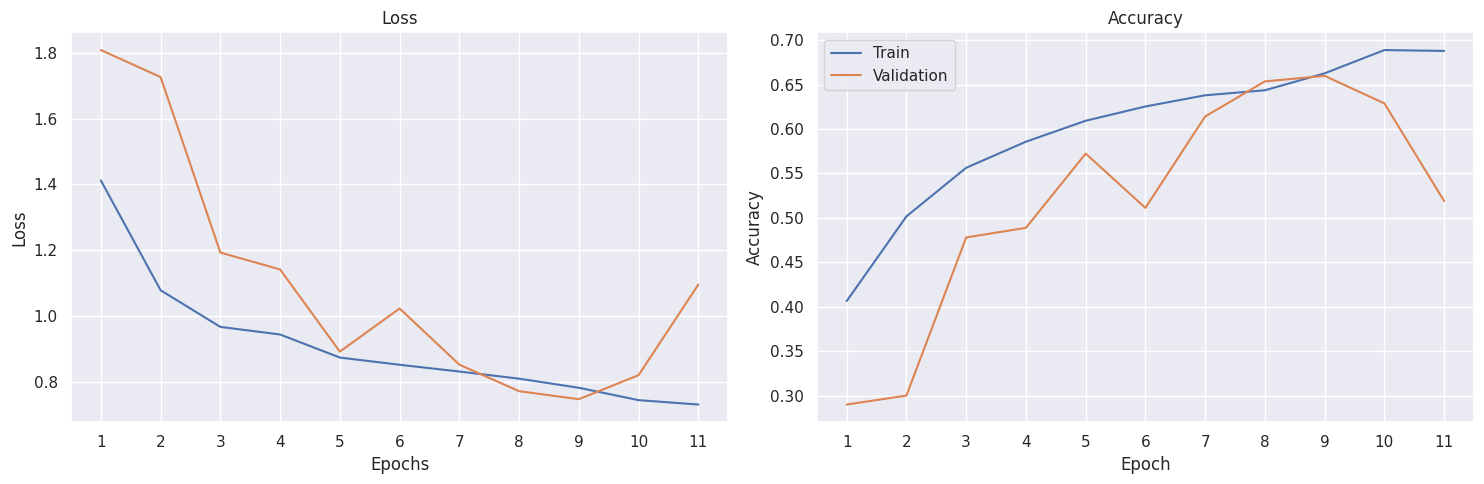

In [192]:
plot_results(history3_2.history['loss'], history3_2.history['accuracy'], history3_2.history['val_loss'], history3_2.history['val_accuracy'])

In [206]:
early_stopping3_3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [207]:
model3_3 = Sequential()

In [208]:
model3_3.add(Input(shape = (80, 80, 3)))
model3_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1))
model3_3.add(BatchNormalization())
model3_3.add(ReLU())
model3_3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3_3.add(Dropout(0.65))
model3_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1))
model3_3.add(BatchNormalization())
model3_3.add(ReLU())
model3_3.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model3_3.add(Dropout(0.65))
model3_3.add(Flatten())
model3_3.add(Dense(128))
model3_3.add(BatchNormalization())
model3_3.add(ReLU())
model3_3.add(Dense(64))
model3_3.add(BatchNormalization())
model3_3.add(ReLU())
model3_3.add(Dropout(0.65))
model3_3.add(Dense(4, activation = 'softmax'))

In [209]:
model3_3.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [210]:
history3_3 = model3_3.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 100, callbacks = [early_stopping3_3])

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4110 - loss: 1.3613 - val_accuracy: 0.3751 - val_loss: 1.5696
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5302 - loss: 0.9878 - val_accuracy: 0.5290 - val_loss: 0.9975
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5824 - loss: 0.9309 - val_accuracy: 0.5568 - val_loss: 0.9385
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6068 - loss: 0.8928 - val_accuracy: 0.5955 - val_loss: 0.8862
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6211 - loss: 0.8685 - val_accuracy: 0.5151 - val_loss: 1.2418
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6442 - loss: 0.8245 - val_accuracy: 0.5886 - val_loss: 0.9218


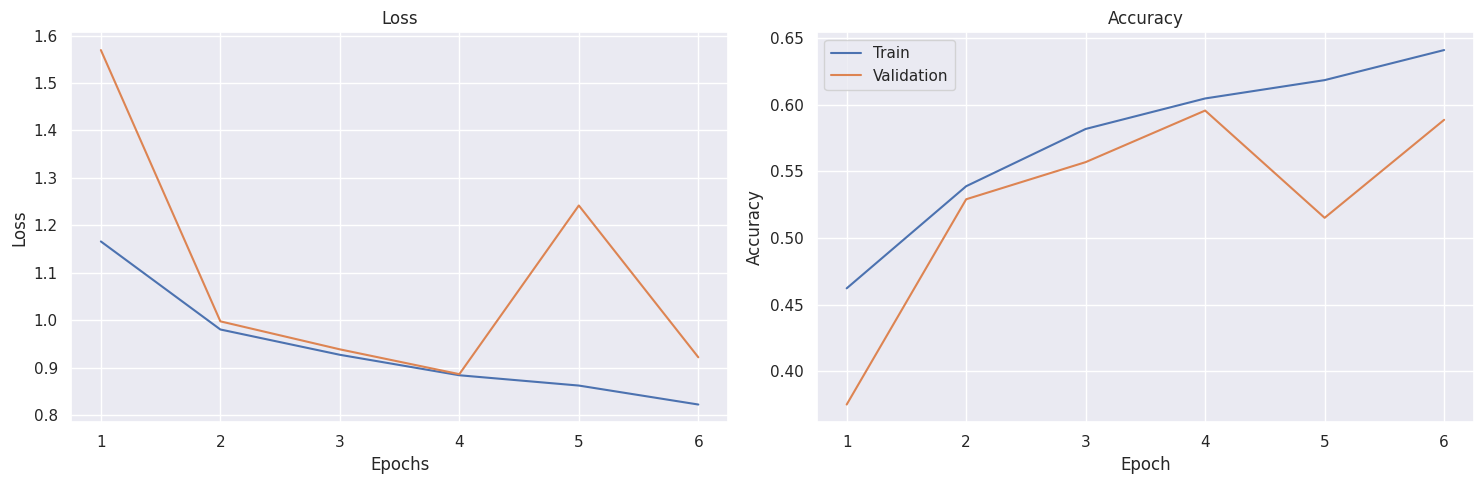

In [211]:
plot_results(history3_3.history['loss'], history3_3.history['accuracy'], history3_3.history['val_loss'], history3_3.history['val_accuracy'])

In [16]:
from keras.applications import ResNet50, EfficientNetV2L, EfficientNetB0, VGG16, DenseNet121, Xception
import tensorflow as tf
from keras.regularizers import l1, l2

In [29]:
base_model1 = ResNet50(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [30]:
early_stopping11 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [31]:
model11 = Sequential()

In [32]:
model11.add(base_model1)
model11.add(Flatten())
model11.add(Dense(4, activation = 'softmax'))

In [33]:
model11.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [34]:
history11 = model11.fit(  
    X_train_scaled,   
    y_train_le,   
    validation_data=(X_val_scaled, y_valid_le),   
    epochs=30 
) 

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 74s 168ms/step - accuracy: 0.5307 - loss: 2.3109 - val_accuracy: 0.2653 - val_loss: 2.2265
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6090 - loss: 1.2884 - val_accuracy: 0.2699 - val_loss: 1.5876
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.6659 - loss: 1.1223 - val_accuracy: 0.3094 - val_loss: 1.7306
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.6600 - loss: 1.0679 - val_accuracy: 0.1779 - val_loss: 2.3923
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7363 - loss: 0.6197 - val_accuracy: 0.5684 - val_loss: 0.9778
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7290 - loss: 0.6536 - val_accuracy: 0.4586 - val_loss: 1.6354
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7227 - loss: 0.7787 - val_accuracy: 0.7355 - val_loss: 0.6103
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8042 - loss: 0.5189 -

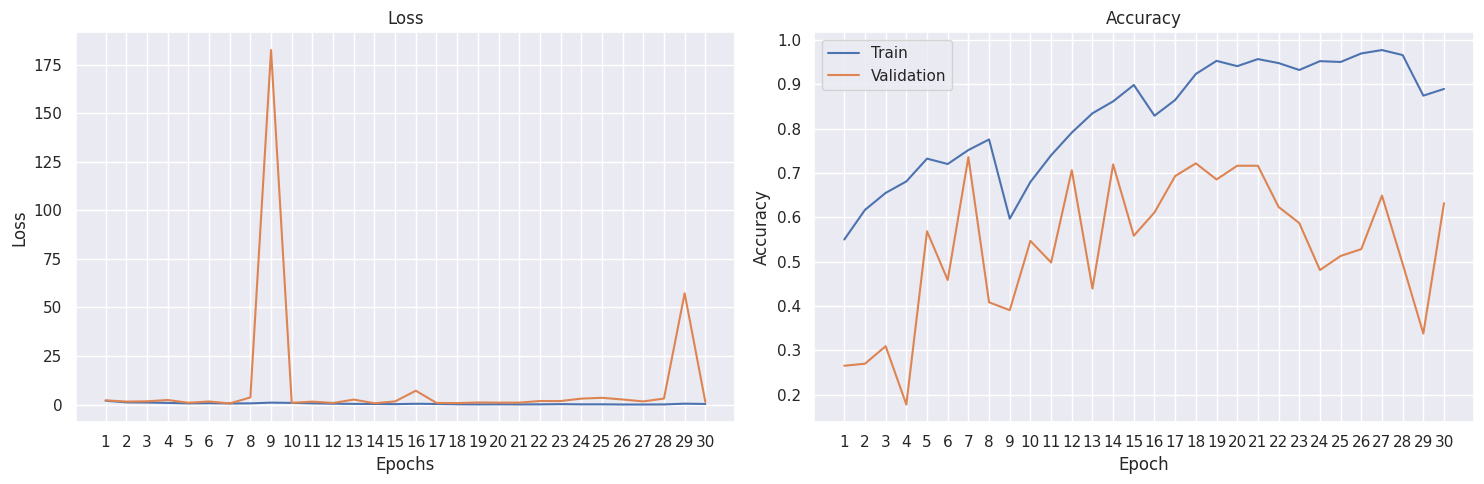

In [37]:
plot_results(history11.history['loss'], history11.history['accuracy'], history11.history['val_loss'], history11.history['val_accuracy'])

In [21]:
base_model2 = EfficientNetV2L(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
model12 = Sequential()

In [23]:
model12.add(base_model2)
model12.add(Flatten())
model12.add(Dense(4, activation = 'softmax'))

In [24]:
model12.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
history12 = model12.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 10, batch_size = 32)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.5692 - loss: 1.0896 - val_accuracy: 0.4973 - val_loss: 1.5534
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 287ms/step - accuracy: 0.8145 - loss: 0.4740 - val_accuracy: 0.1547 - val_loss: 8.0439
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - accuracy: 0.8784 - loss: 0.3308 - val_accuracy: 0.1562 - val_loss: 7.4406
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9046 - loss: 0.2697 - val_accuracy: 0.1547 - val_loss: 9.1591
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9301 - loss: 0.2024 - val_accuracy: 0.5808 - val_loss: 1.3339
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9409 - loss: 0.1606 - val_accuracy: 0.7022 - val_loss: 0.8928
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9303 - loss: 0.2159 - val_accuracy: 0.1725 - val_loss: 5.6225
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.9609 - loss: 0.1

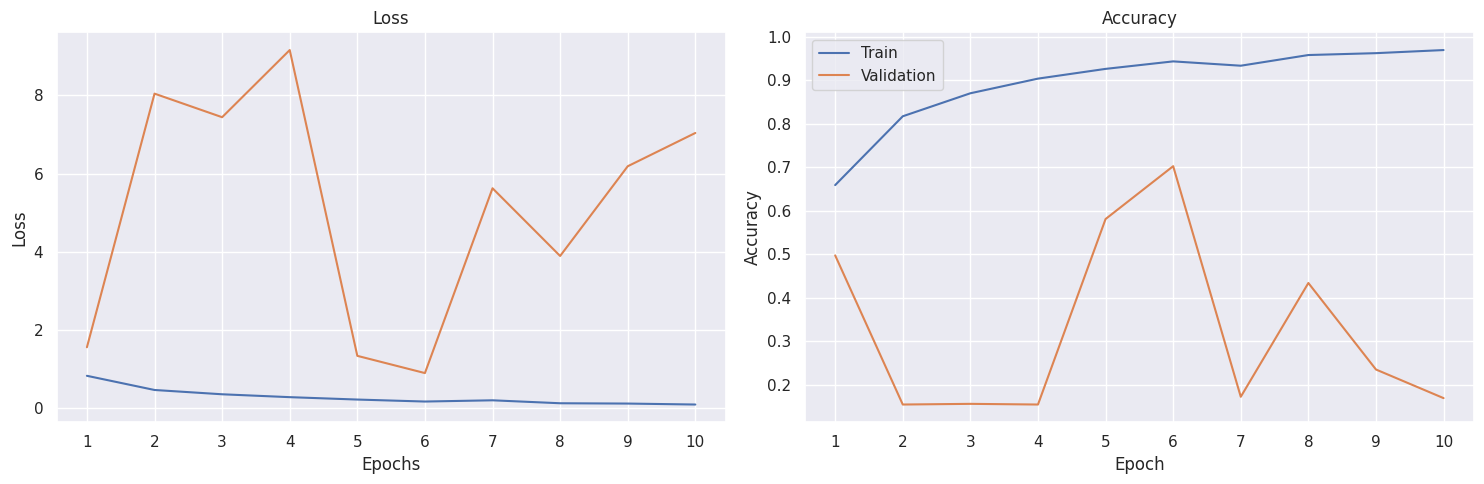

In [26]:
plot_results(history12.history['loss'], history12.history['accuracy'], history12.history['val_loss'], history12.history['val_accuracy'])

In [53]:
base_model3 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [54]:
model13 = Sequential()

In [55]:
model13.add(base_model3)
model13.add(Flatten())
model13.add(Dense(4, activation = 'softmax'))

In [56]:
model13.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [57]:
history13 = model13.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 30, batch_size = 64)

Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 380ms/step - accuracy: 0.5780 - loss: 1.0527 - val_accuracy: 0.1547 - val_loss: 22.0498
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8377 - loss: 0.4076 - val_accuracy: 0.1547 - val_loss: 8.8149
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9016 - loss: 0.2596 - val_accuracy: 0.1547 - val_loss: 109.3756
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9402 - loss: 0.1658 - val_accuracy: 0.1547 - val_loss: 19.0295
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9348 - loss: 0.1848 - val_accuracy: 0.1547 - val_loss: 15.2787
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9341 - loss: 0.1813 - val_accuracy: 0.1555 - val_loss: 12.1891
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9519 - loss: 0.1465 - val_accuracy: 0.2668 - val_loss: 5.0205
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9651 - loss: 0.1020 - val_accuracy: 0.

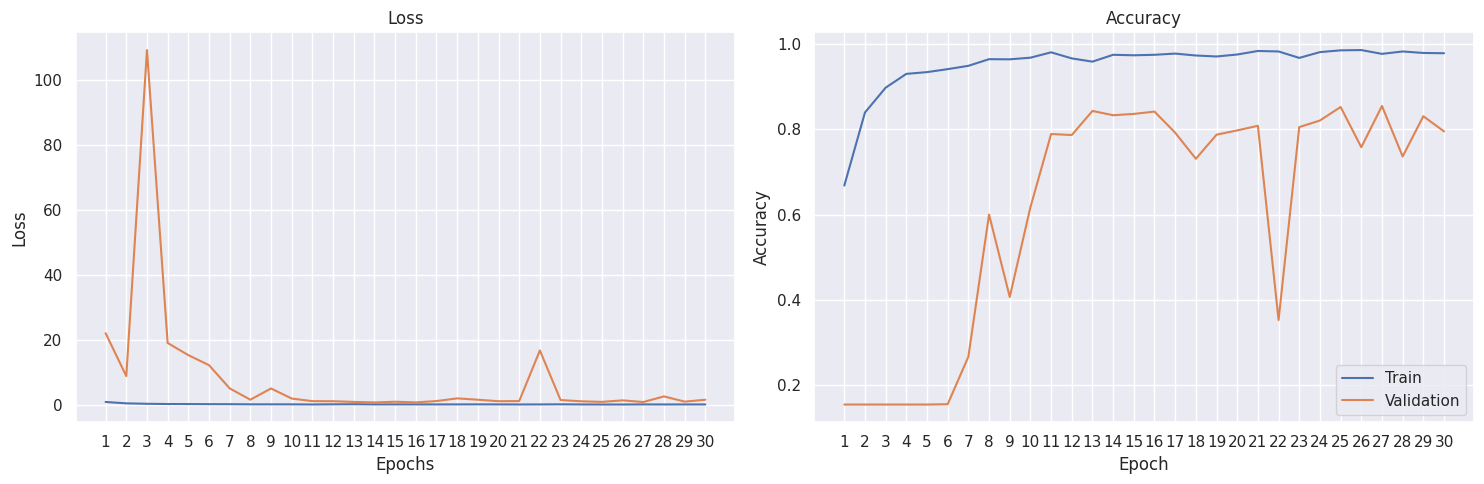

In [58]:
plot_results(history13.history['loss'], history13.history['accuracy'], history13.history['val_loss'], history13.history['val_accuracy'])

In [66]:
base_model3_2 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [67]:
model13_2 = Sequential()

In [68]:
model13_2.add(base_model3_2)
model13_2.add(Dropout(0.50))
model13_2.add(Flatten())
model13_2.add(Dropout(0.50))
model13_2.add(Dense(4, activation = 'softmax'))

In [69]:
model13_2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [70]:
history13_2 = model13_2.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 40, batch_size = 64)

Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 392ms/step - accuracy: 0.5088 - loss: 1.5450 - val_accuracy: 0.1547 - val_loss: 16.8117
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7675 - loss: 0.5784 - val_accuracy: 0.1547 - val_loss: 17.1798
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8398 - loss: 0.4119 - val_accuracy: 0.1547 - val_loss: 23.5802
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8799 - loss: 0.3208 - val_accuracy: 0.1547 - val_loss: 24.0454
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9074 - loss: 0.2683 - val_accuracy: 0.1547 - val_loss: 43.0742
Epoch 6/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9171 - loss: 0.2354 - val_accuracy: 0.2792 - val_loss: 12.1779
Epoch 7/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9376 - loss: 0.1884 - val_accuracy: 0.2243 - val_loss: 12.4138
Epoch 8/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9508 - loss: 0.1395 - val_accuracy: 0

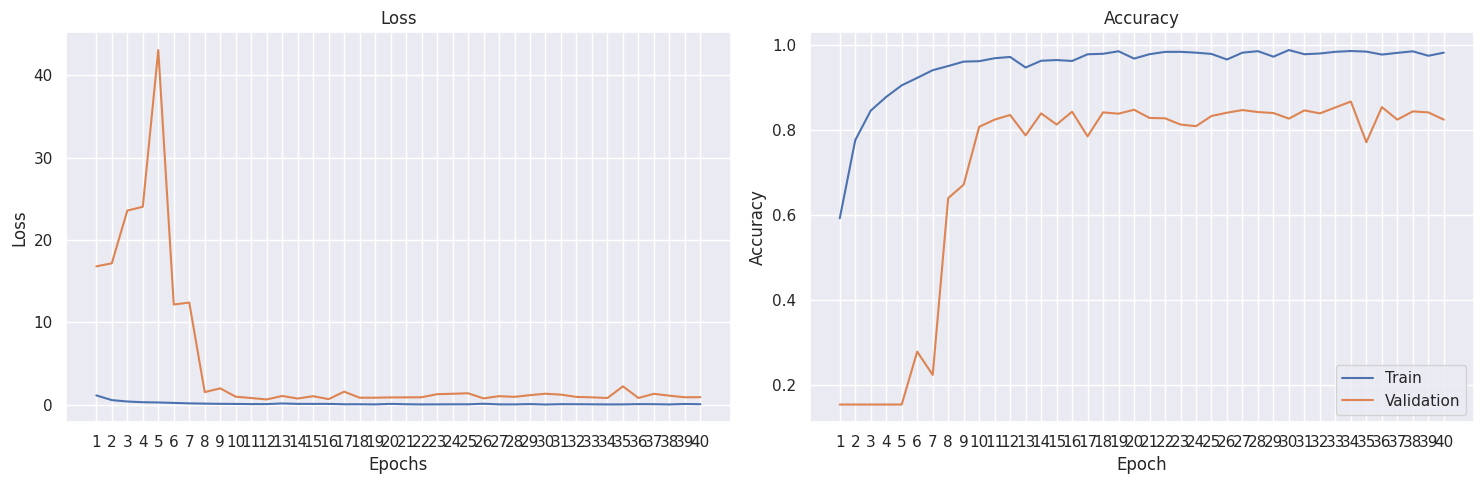

In [71]:
plot_results(history13_2.history['loss'], history13_2.history['accuracy'], history13_2.history['val_loss'], history13_2.history['val_accuracy'])

In [73]:
base_model4 = VGG16(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [74]:
model14 = Sequential()

In [75]:
model14.add(base_model4)
model14.add(Flatten())
model14.add(Dense(4, activation = 'softmax'))

In [76]:
model14.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [77]:
history14 = model14.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 20, batch_size = 64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - accuracy: 0.2910 - loss: 2.0658 - val_accuracy: 0.3898 - val_loss: 1.1702
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.3970 - loss: 1.1885 - val_accuracy: 0.5019 - val_loss: 1.0336
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.4653 - loss: 1.0586 - val_accuracy: 0.4780 - val_loss: 1.0037
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.5450 - loss: 0.9399 - val_accuracy: 0.6079 - val_loss: 0.8605
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.6295 - loss: 0.8268 - val_accuracy: 0.5762 - val_loss: 0.8497
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.6417 - loss: 0.7698 - val_accuracy: 0.6914 - val_loss: 0.7127
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.7069 - loss: 0.6582 - val_accuracy: 0.6613 - val_loss: 0.7526
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.7072 - loss: 0.6556 - val_accu

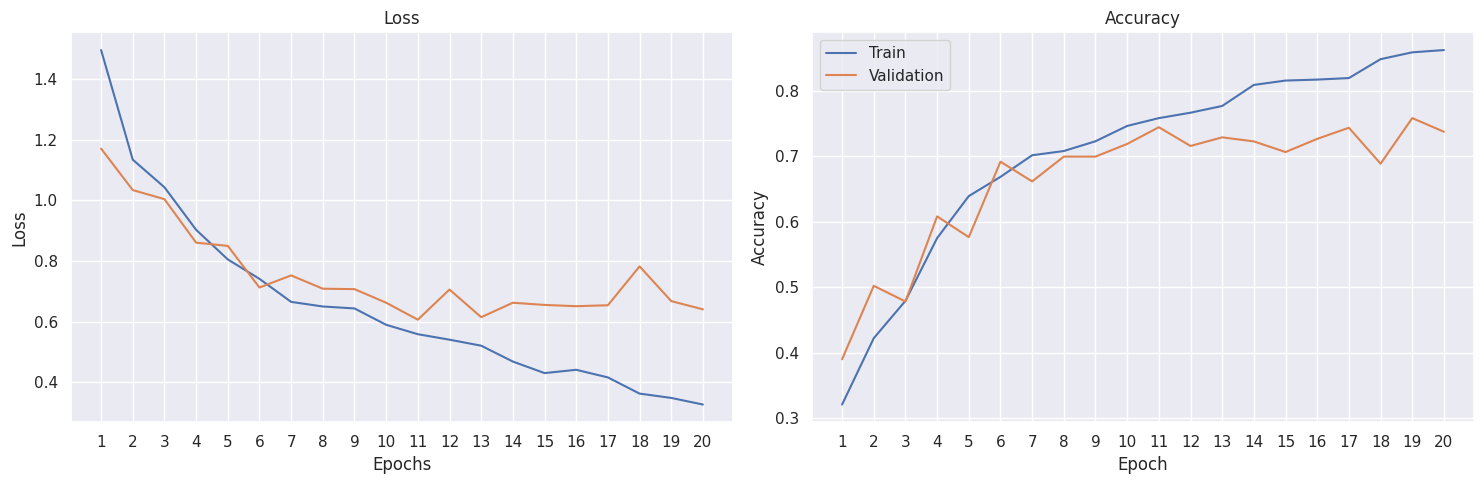

In [78]:
plot_results(history14.history['loss'], history14.history['accuracy'], history14.history['val_loss'], history14.history['val_accuracy'])

In [80]:
base_model5 = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [81]:
model15 = Sequential()

In [82]:
model15.add(base_model5)
model15.add(Flatten())
model15.add(Dense(4, activation = 'softmax'))

In [83]:
model15.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [84]:
history15 = model15.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 20, batch_size = 64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 216s 976ms/step - accuracy: 0.6219 - loss: 0.9864 - val_accuracy: 0.2862 - val_loss: 239.6077
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7432 - loss: 0.6518 - val_accuracy: 0.6427 - val_loss: 2.9922
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8168 - loss: 0.4745 - val_accuracy: 0.3442 - val_loss: 139.9928
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8092 - loss: 0.4738 - val_accuracy: 0.7726 - val_loss: 0.6293
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8716 - loss: 0.3240 - val_accuracy: 0.6729 - val_loss: 0.9907
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9112 - loss: 0.2226 - val_accuracy: 0.5538 - val_loss: 2.2134
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9378 - loss: 0.2187 - val_accuracy: 0.6930 - val_loss: 1.2543
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9284 - loss: 0.1815 - val

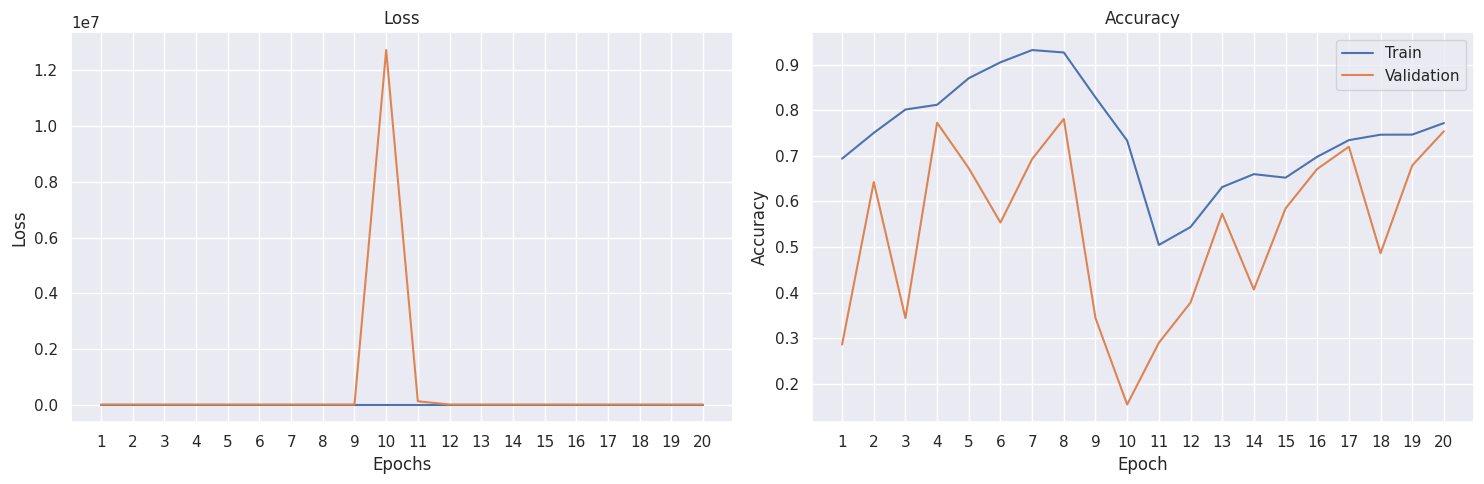

In [85]:
plot_results(history15.history['loss'], history15.history['accuracy'], history15.history['val_loss'], history15.history['val_accuracy'])

In [87]:
base_model6 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [88]:
model16 = Sequential()

In [89]:
model16.add(base_model6)
model16.add(Flatten())
model16.add(Dense(4, activation = 'softmax'))

In [90]:
model16.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [91]:
history16 = model16.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 20, batch_size = 64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 70s 324ms/step - accuracy: 0.6109 - loss: 0.9174 - val_accuracy: 0.7386 - val_loss: 0.7836
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8686 - loss: 0.3466 - val_accuracy: 0.7966 - val_loss: 0.5558
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9092 - loss: 0.2851 - val_accuracy: 0.8213 - val_loss: 0.8141
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9507 - loss: 0.1474 - val_accuracy: 0.7154 - val_loss: 1.2727
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9662 - loss: 0.0925 - val_accuracy: 0.8252 - val_loss: 0.6284
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9786 - loss: 0.0674 - val_accuracy: 0.7788 - val_loss: 1.1550
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9788 - loss: 0.0665 - val_accuracy: 0.8268 - val_loss: 0.9286
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9832 - loss: 0.0517 - val_accu

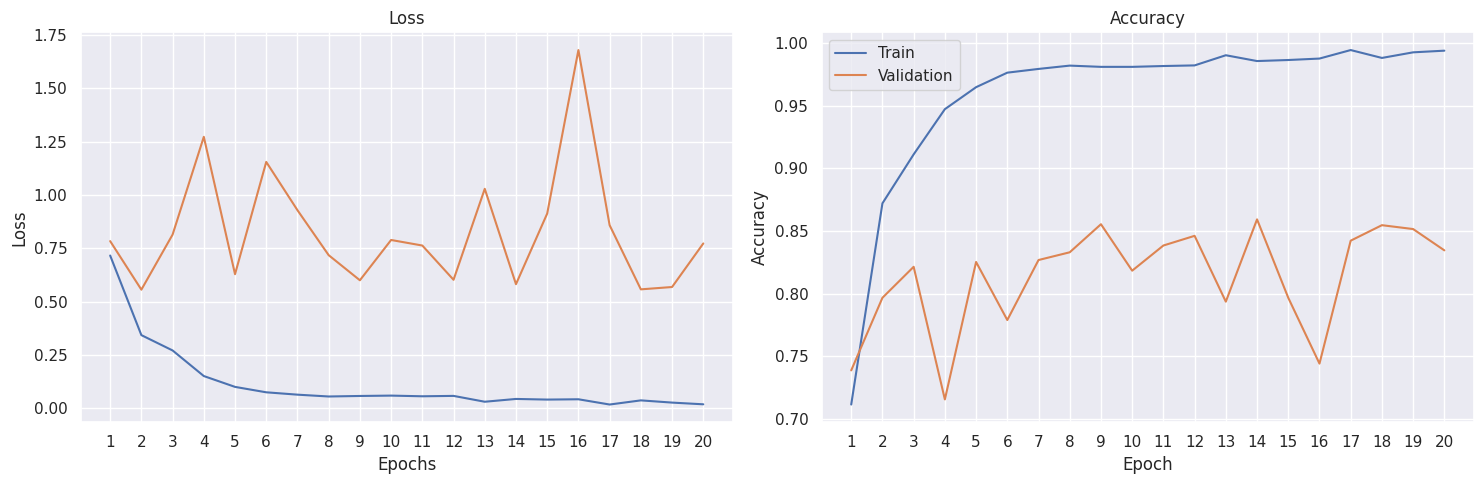

In [92]:
plot_results(history16.history['loss'], history16.history['accuracy'], history16.history['val_loss'], history16.history['val_accuracy'])

In [100]:
base_model6_2 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [101]:
model16_2 = Sequential()

In [102]:
model16_2.add(base_model6_2)  
model16_2.add(Flatten())  
model16_2.add(Dropout(0.5)) 
model16_2.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))    
model16_2.add(BatchNormalization())

In [103]:
model16_2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [104]:
history16_2 = model16_2.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 20, batch_size = 64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 64s 303ms/step - accuracy: 0.3133 - loss: 7.9084 - val_accuracy: 0.1740 - val_loss: 4.9445
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2215 - loss: 6.4732 - val_accuracy: 0.2475 - val_loss: 11.0777
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2593 - loss: 6.1890 - val_accuracy: 0.1547 - val_loss: 13.6710
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.2821 - loss: 4.3895 - val_accuracy: 0.2838 - val_loss: 8.9535
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.2832 - loss: 6.7948 - val_accuracy: 0.2970 - val_loss: 9.3562
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.2998 - loss: 5.7478 - val_accuracy: 0.2792 - val_loss: 6.3327
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.2865 - loss: 3.3230 - val_accuracy: 0.2923 - val_loss: 6.3636
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.2912 - loss: 2.5325 - val_ac

In [17]:
base_model6_3 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [18]:
model16_3 = Sequential()

In [19]:
model16_3.add(base_model6_3)  
model16_3.add(Flatten())  
model16_3.add(Dropout(0.5)) 
model16_3.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.001)))    
model16_3.add(BatchNormalization())

In [20]:
model16_3.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [21]:
history16_3 = model16_3.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 20, batch_size = 64)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 73s 332ms/step - accuracy: 0.3192 - loss: 6.2039 - val_accuracy: 0.2475 - val_loss: 2.4498
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.2592 - loss: 4.8894 - val_accuracy: 0.2537 - val_loss: 3.7656
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.1997 - loss: 5.1669 - val_accuracy: 0.2792 - val_loss: 9.7495
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.1801 - loss: 5.3338 - val_accuracy: 0.1400 - val_loss: 6.6798
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.1694 - loss: 5.0468 - val_accuracy: 0.3009 - val_loss: 4.7608
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.2045 - loss: 4.9037 - val_accuracy: 0.2939 - val_loss: 11.2210
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.1990 - loss: 3.0887 - val_accuracy: 0.2328 - val_loss: 4.3109
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.1614 - loss: 1.5862 - val_acc

In [40]:
base_model6_4 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [41]:
model16_4 = Sequential()

In [42]:
model16_4.add(base_model6_4)  
model16_4.add(Flatten())  
model16_4.add(Dropout(0.2)) 
model16_4.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))    
model16_4.add(BatchNormalization())

In [43]:
model16_4.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [44]:
history16_4 = model16_4.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 10, batch_size = 64)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 61s 304ms/step - accuracy: 0.4408 - loss: 2.6620 - val_accuracy: 0.1848 - val_loss: 11.1675
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5221 - loss: 1.7537 - val_accuracy: 0.5360 - val_loss: 1.7174
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.4349 - loss: 2.6334 - val_accuracy: 0.3480 - val_loss: 2.4026
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.3420 - loss: 2.4336 - val_accuracy: 0.3619 - val_loss: 2.2322
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.3485 - loss: 2.5730 - val_accuracy: 0.3449 - val_loss: 2.3409
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.3656 - loss: 2.3127 - val_accuracy: 0.3194 - val_loss: 2.8870
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.3295 - loss: 4.1218 - val_accuracy: 0.2622 - val_loss: 7.3973
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.2854 - loss: 5.3272 - val_acc

In [45]:
base_model6_5 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [46]:
model16_5 = Sequential()

In [47]:
model16_5.add(base_model6_5)  
model16_5.add(Flatten())  
model16_5.add(Dropout(0.2)) 
model16_5.add(Dense(4, activation='softmax'))    
model16_5.add(BatchNormalization())

In [48]:
model16_5.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [49]:
history16_5 = model16_5.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 10, batch_size = 64)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 61s 308ms/step - accuracy: 0.3682 - loss: 5.5721 - val_accuracy: 0.1779 - val_loss: 12.2584
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.3729 - loss: 2.4135 - val_accuracy: 0.3968 - val_loss: 1.6662
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.3721 - loss: 1.9455 - val_accuracy: 0.3890 - val_loss: 1.7260
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.4069 - loss: 1.5267 - val_accuracy: 0.3952 - val_loss: 2.0024
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.3658 - loss: 2.2316 - val_accuracy: 0.3929 - val_loss: 1.7167
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.4026 - loss: 1.6680 - val_accuracy: 0.3797 - val_loss: 2.1164
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.4073 - loss: 1.7069 - val_accuracy: 0.4207 - val_loss: 1.3272
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.4249 - loss: 1.4310 - val_acc

In [54]:
base_model6_6 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [55]:
model16_6 = Sequential()

In [56]:
model16_6.add(base_model6_6)  
model16_6.add(Flatten())  
model16_6.add(Dropout(0.2)) 
model16_6.add(Dense(4, activation='softmax'))    

In [57]:
model16_6.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [58]:
history16_6 = model16_6.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 10, batch_size = 64)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 58s 301ms/step - accuracy: 0.5490 - loss: 0.9760 - val_accuracy: 0.7340 - val_loss: 1.4065
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.8530 - loss: 0.3960 - val_accuracy: 0.7370 - val_loss: 1.2090
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9239 - loss: 0.2183 - val_accuracy: 0.6976 - val_loss: 0.9505
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9526 - loss: 0.1340 - val_accuracy: 0.8097 - val_loss: 0.6579
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9684 - loss: 0.0932 - val_accuracy: 0.8531 - val_loss: 0.5238
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9805 - loss: 0.0580 - val_accuracy: 0.8105 - val_loss: 0.8772
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9625 - loss: 0.0977 - val_accuracy: 0.7997 - val_loss: 0.8918
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9694 - loss: 0.0938 - val_accu

In [69]:
base_model6_7 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [70]:
model16_7 = Sequential()

In [71]:
model16_7.add(base_model6_7)  
model16_7.add(Flatten())  
model16_7.add(Dropout(0.5)) 
model16_7.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.1)))  

In [72]:
model16_7.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
history16_7 = model16_7.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 10, batch_size = 64)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 61s 303ms/step - accuracy: 0.5396 - loss: 1.3510 - val_accuracy: 0.5971 - val_loss: 4.9891
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.8563 - loss: 0.4466 - val_accuracy: 0.7904 - val_loss: 0.6840
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9267 - loss: 0.2746 - val_accuracy: 0.7788 - val_loss: 0.8019
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9667 - loss: 0.1300 - val_accuracy: 0.7463 - val_loss: 0.9888
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9546 - loss: 0.1669 - val_accuracy: 0.7363 - val_loss: 1.3376
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9725 - loss: 0.1078 - val_accuracy: 0.8384 - val_loss: 0.6718
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9780 - loss: 0.0817 - val_accuracy: 0.7138 - val_loss: 1.1892
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9741 - loss: 0.0939 - val_accu

In [74]:
base_model6_8 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [75]:
model16_8 = Sequential()

In [76]:
model16_8.add(base_model6_8)  
model16_8.add(Flatten())  
model16_8.add(Dropout(0.8)) 
model16_8.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.1))) 

In [77]:
model16_8.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [78]:
history16_8 = model16_8.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 15, batch_size = 64)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 58s 293ms/step - accuracy: 0.5059 - loss: 1.4374 - val_accuracy: 0.6396 - val_loss: 3.1510
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.8475 - loss: 0.5132 - val_accuracy: 0.6937 - val_loss: 1.3786
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9079 - loss: 0.3328 - val_accuracy: 0.8221 - val_loss: 0.5490
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9444 - loss: 0.2014 - val_accuracy: 0.7649 - val_loss: 0.9614
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9578 - loss: 0.1570 - val_accuracy: 0.8005 - val_loss: 0.9893
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9739 - loss: 0.1153 - val_accuracy: 0.7680 - val_loss: 0.8643
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9808 - loss: 0.0990 - val_accuracy: 0.8430 - val_loss: 0.5624
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9663 - loss: 0.1712 - val_accu

In [79]:
base_model6_9 = Xception(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [80]:
model16_9 = Sequential()

In [81]:
model16_9.add(base_model6_9)  
model16_9.add(Flatten())  
model16_9.add(Dropout(0.8)) 
model16_9.add(Dense(4, activation='softmax', kernel_regularizer=l1(0.01))) 

In [82]:
model16_9.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [83]:
history16_9 = model16_9.fit(X_train_scaled, y_train_le, validation_data = (X_val_scaled, y_valid_le), epochs = 15, batch_size = 64)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 59s 301ms/step - accuracy: 0.5449 - loss: 3.5485 - val_accuracy: 0.7262 - val_loss: 1.3994
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8646 - loss: 0.7412 - val_accuracy: 0.6326 - val_loss: 2.0455
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9167 - loss: 0.5959 - val_accuracy: 0.6906 - val_loss: 1.6366
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9576 - loss: 0.3740 - val_accuracy: 0.7842 - val_loss: 1.0645
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9567 - loss: 0.3463 - val_accuracy: 0.8561 - val_loss: 0.6435
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9738 - loss: 0.2943 - val_accuracy: 0.8144 - val_loss: 0.9674
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9550 - loss: 0.4090 - val_accuracy: 0.7108 - val_loss: 1.4171
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.9848 - loss: 0.2308 - val_accu